# Problem Statement
___

- https://medium.com/mlearning-ai/a-thorough-dive-into-the-ames-iowa-housing-dataset-part-1-of-5-7205093a5a53
- https://github.com/jesservillines/Housing-Prices
- https://nycdatascience.com/blog/student-works/machine-learning-project/
- http://jse.amstat.org/v19n3/decock/DataDocumentation.txt

# 0.0 Import libraries
___

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split , cross_validate , cross_val_score
from sklearn.linear_model import LinearRegression , Lasso , Ridge
from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# 0.5 Function Creation
___

In [3]:
def EDA_subplot(nrows , ncols , feature_list , df):

    plt.figure(figsize = (ncols*10 , nrows*8))
    for i in range(len(feature_list)):
        plt.subplot(nrows , ncols , i+1)
        
        # If numeric data feature , plot scatter
        if pd.api.types.is_numeric_dtype(df[feature_list[i]]):
        
            sns.scatterplot(data = df,
                            x = feature_list[i],
                            y = 'Log SalePrice')
            plt.title(f'{feature_list[i]} vs Sale Price')
            plt.tight_layout(h_pad = 2)
        
        # If non - numeric data feature , plot boxplot
        else:
            sns.boxplot(data = df,
                        x = feature_list[i],
                        y = 'Log SalePrice')
            plt.title(f'{feature_list[i]} vs Sale Price')
            plt.xticks(rotation = 90)
            plt.tight_layout(h_pad = 2)            

In [4]:
def minority_feature_dummify(df , col_name):
    print('Before Dummify:')
    print('=======================')
    print(df[col_name].value_counts())
    
    for index , data in enumerate(df[col_name]):
        if pd.isna(data):
            df.loc[index , col_name] = 0
        else:
            df.loc[index , col_name] = 1
    
    print('                       ')
    print('After Dummify:')
    print('=======================')
    print(df[col_name].value_counts())

In [ ]:
mean_squared_error()

In [5]:
def eval_pred(model):
    
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    
    scores = {'Training MAE': mean_absolute_error(y_train , train_pred),
              'Validation MAE' : mean_absolute_error(y_val , val_pred),
              'Training RMSE': mean_squared_error(y_train , train_pred , squared = False),
              'Validation RMSE' : mean_squared_error(y_val , val_pred , squared = False),
              'Training R^2 Score' :r2_score(y_train , train_pred),
              'Validation R^2 Score' : r2_score(y_val , val_pred),
              'Training Model Score' : model.score(X_train, y_train),
              'Validation Model Score' : model.score(X_val , y_val)}
    
    
    df_score = pd.DataFrame({'Score' : scores.values()}, 
                              index = scores.keys())
    return df_score

# 1.0 Exploring Datasets
___

The aim of Section 1.0 is to have an overview of the dataset distribution for most of the features and have a broad understanding of the variables in each features. We will also check for outliers ,datatype accuracy and clean them out prior to the feature engineering studies in Section 2.0.

- 1.1 Dataset Overview
- 1.2 Exploring Null Values
- 1.3 Exploring Duplicates
- 1.4 General Overview of dataset
    - 1.4a General Overview for Date Features
    - 1.4b General Overview for Basement Features    
    - 1.4c General Overview for Garage Features
    - 1.4d General Overview for Heating Features
    - 1.4e General Overview for Porch Features
    - 1.4f General Overview for House Ext. Features    
    - 1.4g General Overview for House Int. Features
    - 1.4h General Overview for Land Plot and Access to Plot Features
    - 1.4i General Overview for House Surronding Features
- 1.5 Renaming Columns for consistency
- 1.6 Pre-processing Missing Value
- 1.7 Pre-processing Outlier Value

In [6]:
df_sub = pd.read_csv('datasets/sample_sub_reg.csv')
df_train = pd.read_csv('datasets/train.csv')
df_test = pd.read_csv('datasets/test.csv')

In [7]:
df_train.head()

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley  \
0  109  533352170           60        RL           NaN     13517   Pave   NaN   
1  544  531379050           60        RL          43.0     11492   Pave   NaN   
2  153  535304180           20        RL          68.0      7922   Pave   NaN   
3  318  916386060           60        RL          73.0      9802   Pave   NaN   
4  255  906425045           50        RL          82.0     14235   Pave   NaN   

  Lot Shape Land Contour  ... Screen Porch Pool Area Pool QC Fence  \
0       IR1          Lvl  ...            0         0     NaN   NaN   
1       IR1          Lvl  ...            0         0     NaN   NaN   
2       Reg          Lvl  ...            0         0     NaN   NaN   
3       Reg          Lvl  ...            0         0     NaN   NaN   
4       IR1          Lvl  ...            0         0     NaN   NaN   

  Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  
0          NaN        0       3    2010        WD      130500  
1          NaN        0       4    2009        WD      220000  
2          NaN        0       1    2010        WD      109000  
3          NaN        0       4    2010        WD      174000  
4          NaN        0       3    2010        WD      138500  

[5 rows x 81 columns]

In [8]:
df_train.columns

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'G

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

In [10]:
df_train.describe()

Id           PID  MS SubClass  Lot Frontage       Lot Area  \
count  2051.000000  2.051000e+03  2051.000000   1721.000000    2051.000000   
mean   1474.033642  7.135900e+08    57.008776     69.055200   10065.208191   
std     843.980841  1.886918e+08    42.824223     23.260653    6742.488909   
min       1.000000  5.263011e+08    20.000000     21.000000    1300.000000   
25%     753.500000  5.284581e+08    20.000000     58.000000    7500.000000   
50%    1486.000000  5.354532e+08    50.000000     68.000000    9430.000000   
75%    2198.000000  9.071801e+08    70.000000     80.000000   11513.500000   
max    2930.000000  9.241520e+08   190.000000    313.000000  159000.000000   

       Overall Qual  Overall Cond   Year Built  Year Remod/Add  Mas Vnr Area  \
count   2051.000000   2051.000000  2051.000000     2051.000000   2029.000000   
mean       6.112140      5.562165  1971.708922     1984.190151     99.695909   
std        1.426271      1.104497    30.177889       21.036250    174.963129   
min        1.000000      1.000000  1872.000000     1950.000000      0.000000   
25%        5.000000      5.000000  1953.500000     1964.500000      0.000000   
50%        6.000000      5.000000  1974.000000     1993.000000      0.000000   
75%        7.000000      6.000000  2001.000000     2004.000000    161.000000   
max       10.000000      9.000000  2010.000000     2010.000000   1600.000000   

       ...  Wood Deck SF  Open Porch SF  Enclosed Porch   3Ssn Porch  \
count  ...   2051.000000    2051.000000     2051.000000  2051.000000   
mean   ...     93.833740      47.556802       22.571916     2.591419   
std    ...    128.549416      66.747241       59.845110    25.229615   
min    ...      0.000000       0.000000        0.000000     0.000000   
25%    ...      0.000000       0.000000        0.000000     0.000000   
50%    ...      0.000000      27.000000        0.000000     0.000000   
75%    ...    168.000000      70.000000        0.000000     0.000000   
max    ...   1424.000000     547.000000      432.000000   508.000000   

       Screen Porch    Pool Area      Misc Val      Mo Sold      Yr Sold  \
count   2051.000000  2051.000000   2051.000000  2051.000000  2051.000000   
mean      16.511458     2.397855     51.574354     6.219893  2007.775719   
std       57.374204    37.782570    573.393985     2.744736     1.312014   
min        0.000000     0.000000      0.000000     1.000000  2006.000000   
25%        0.000000     0.000000      0.000000     4.000000  2007.000000   
50%        0.000000     0.000000      0.000000     6.000000  2008.000000   
75%        0.000000     0.000000      0.000000     8.000000  2009.000000   
max      490.000000   800.000000  17000.000000    12.000000  2010.000000   

           SalePrice  
count    2051.000000  
mean   181469.701609  
std     79258.659352  
min     12789.000000  
25%    129825.000000  
50%    162500.000000  
75%    214000.000000  
max    611657.000000  

[8 rows x 39 columns]

### 1.1 Dataset overview
___

In [11]:
print('Train data shape: ' , df_train.shape)
print('Train data dim: ' , df_train.ndim)
print('Train data size: ' , df_train.size)
print('Test data shape: ' , df_test.shape)
print('Test data dim: ' , df_test.ndim)
print('Test data size: ' , df_test.size)

Train data shape:  (2051, 81)
Train data dim:  2
Train data size:  166131
Test data shape:  (878, 80)
Test data dim:  2
Test data size:  70240


### 1.2 Exploring Null Value
___

Text(0, 0.5, 'Features')

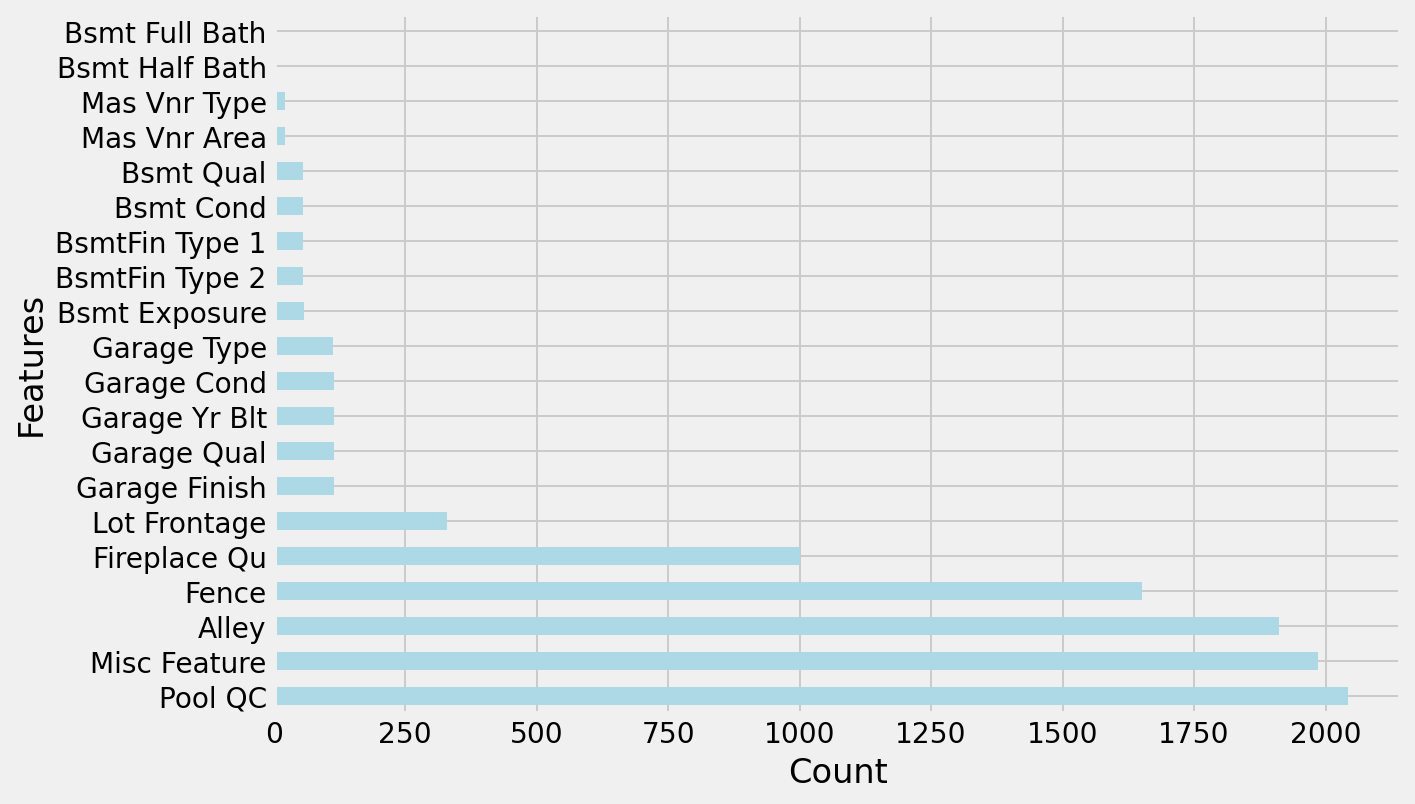

In [12]:
# Visualing Null Value Count for Features
x = df_train.isnull().sum().sort_values(ascending = False).head(20)

plt.figure(figsize = (9,6))
x.plot(kind = 'barh' , color = 'lightblue')

plt.xlabel('Count')
plt.ylabel('Features')

### 1.3 Exploring Duplicates
___

In [13]:
df_train.duplicated().sum()

0

### 1.4  General Overview of Numeric and Non-numeric features
___

In [14]:
# Finding Numeric Features
numeric_list = []
for col_name , data in df_train.items():
    if pd.api.types.is_numeric_dtype(data):
        numeric_list.append(col_name)
        
print(numeric_list)

['Id', 'PID', 'MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold', 'SalePrice']


In [15]:
# Finding Categorical Features
cat_list = []
for col_name , data in df_train.items():
    if not pd.api.types.is_numeric_dtype(data):
        cat_list.append(col_name)
        
print(cat_list)

['MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC', 'Central Air', 'Electrical', 'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence', 'Misc Feature', 'Sale Type']


### 1.4 General Overview of Sales Distribution and Data Visualisation (For Relation & Outliers)
___
Since the Log of the SalePrice give a better normal distribution , we will be using that for subsequent comparison against other features

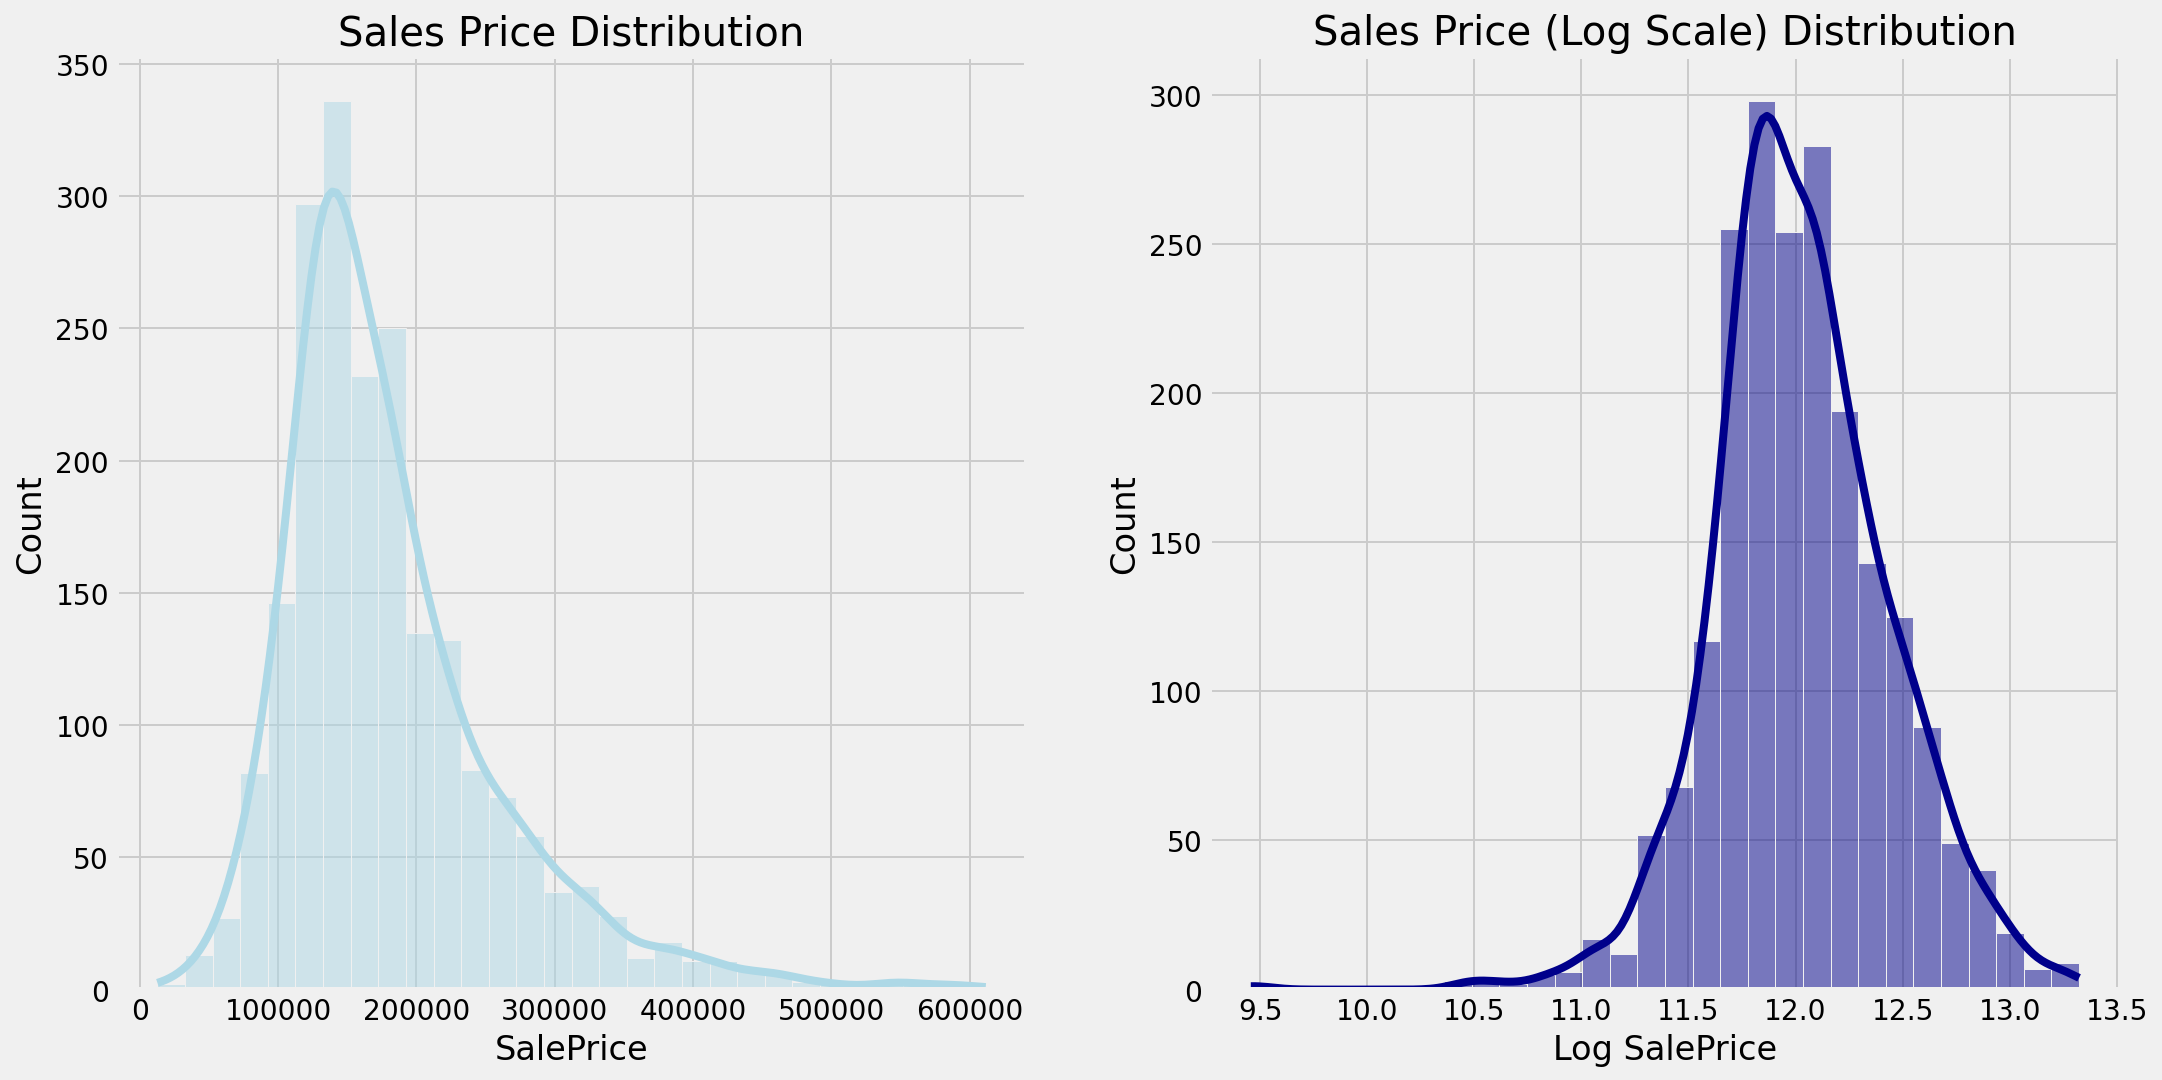

In [16]:
plt.figure(figsize = (16,8))

# Sales Price Distribution
plt.subplot(1,2,1)
sns.histplot(data = df_train,
             x = 'SalePrice',
             stat = 'count',
             color = 'lightblue',
             bins = 30,
             kde = True)
plt.title('Sales Price Distribution')

# Log Sales Price Distribution

df_train['Log SalePrice'] = np.log(df_train['SalePrice']) # Create new column for Log value of SalePrice

plt.subplot(1,2,2)
sns.histplot(data = df_train,
             x = 'Log SalePrice',
             stat = 'count',
             color = 'darkblue',
             bins = 30,
             kde = True)
             
plt.title('Sales Price (Log Scale) Distribution');


### 1.4a General Overview on Date Features
___

- Created a feature called Building Age =  Yr Sold - Year Built
- Base on Date features , the year sold between 2006 to 2010 seem fairly consistent for the sales price. Except the outlier , there are no special surge in sales price for house sold in later years

- House built more recently generally is able to be sold at a higher price. 

In [17]:
df_train[~(df_train['Yr Sold'] > df_train['Year Built'])][['Yr Sold' , 'Year Built']].head()

Yr Sold  Year Built
41      2006        2006
61      2007        2007
65      2007        2007
85      2006        2006
138     2006        2006

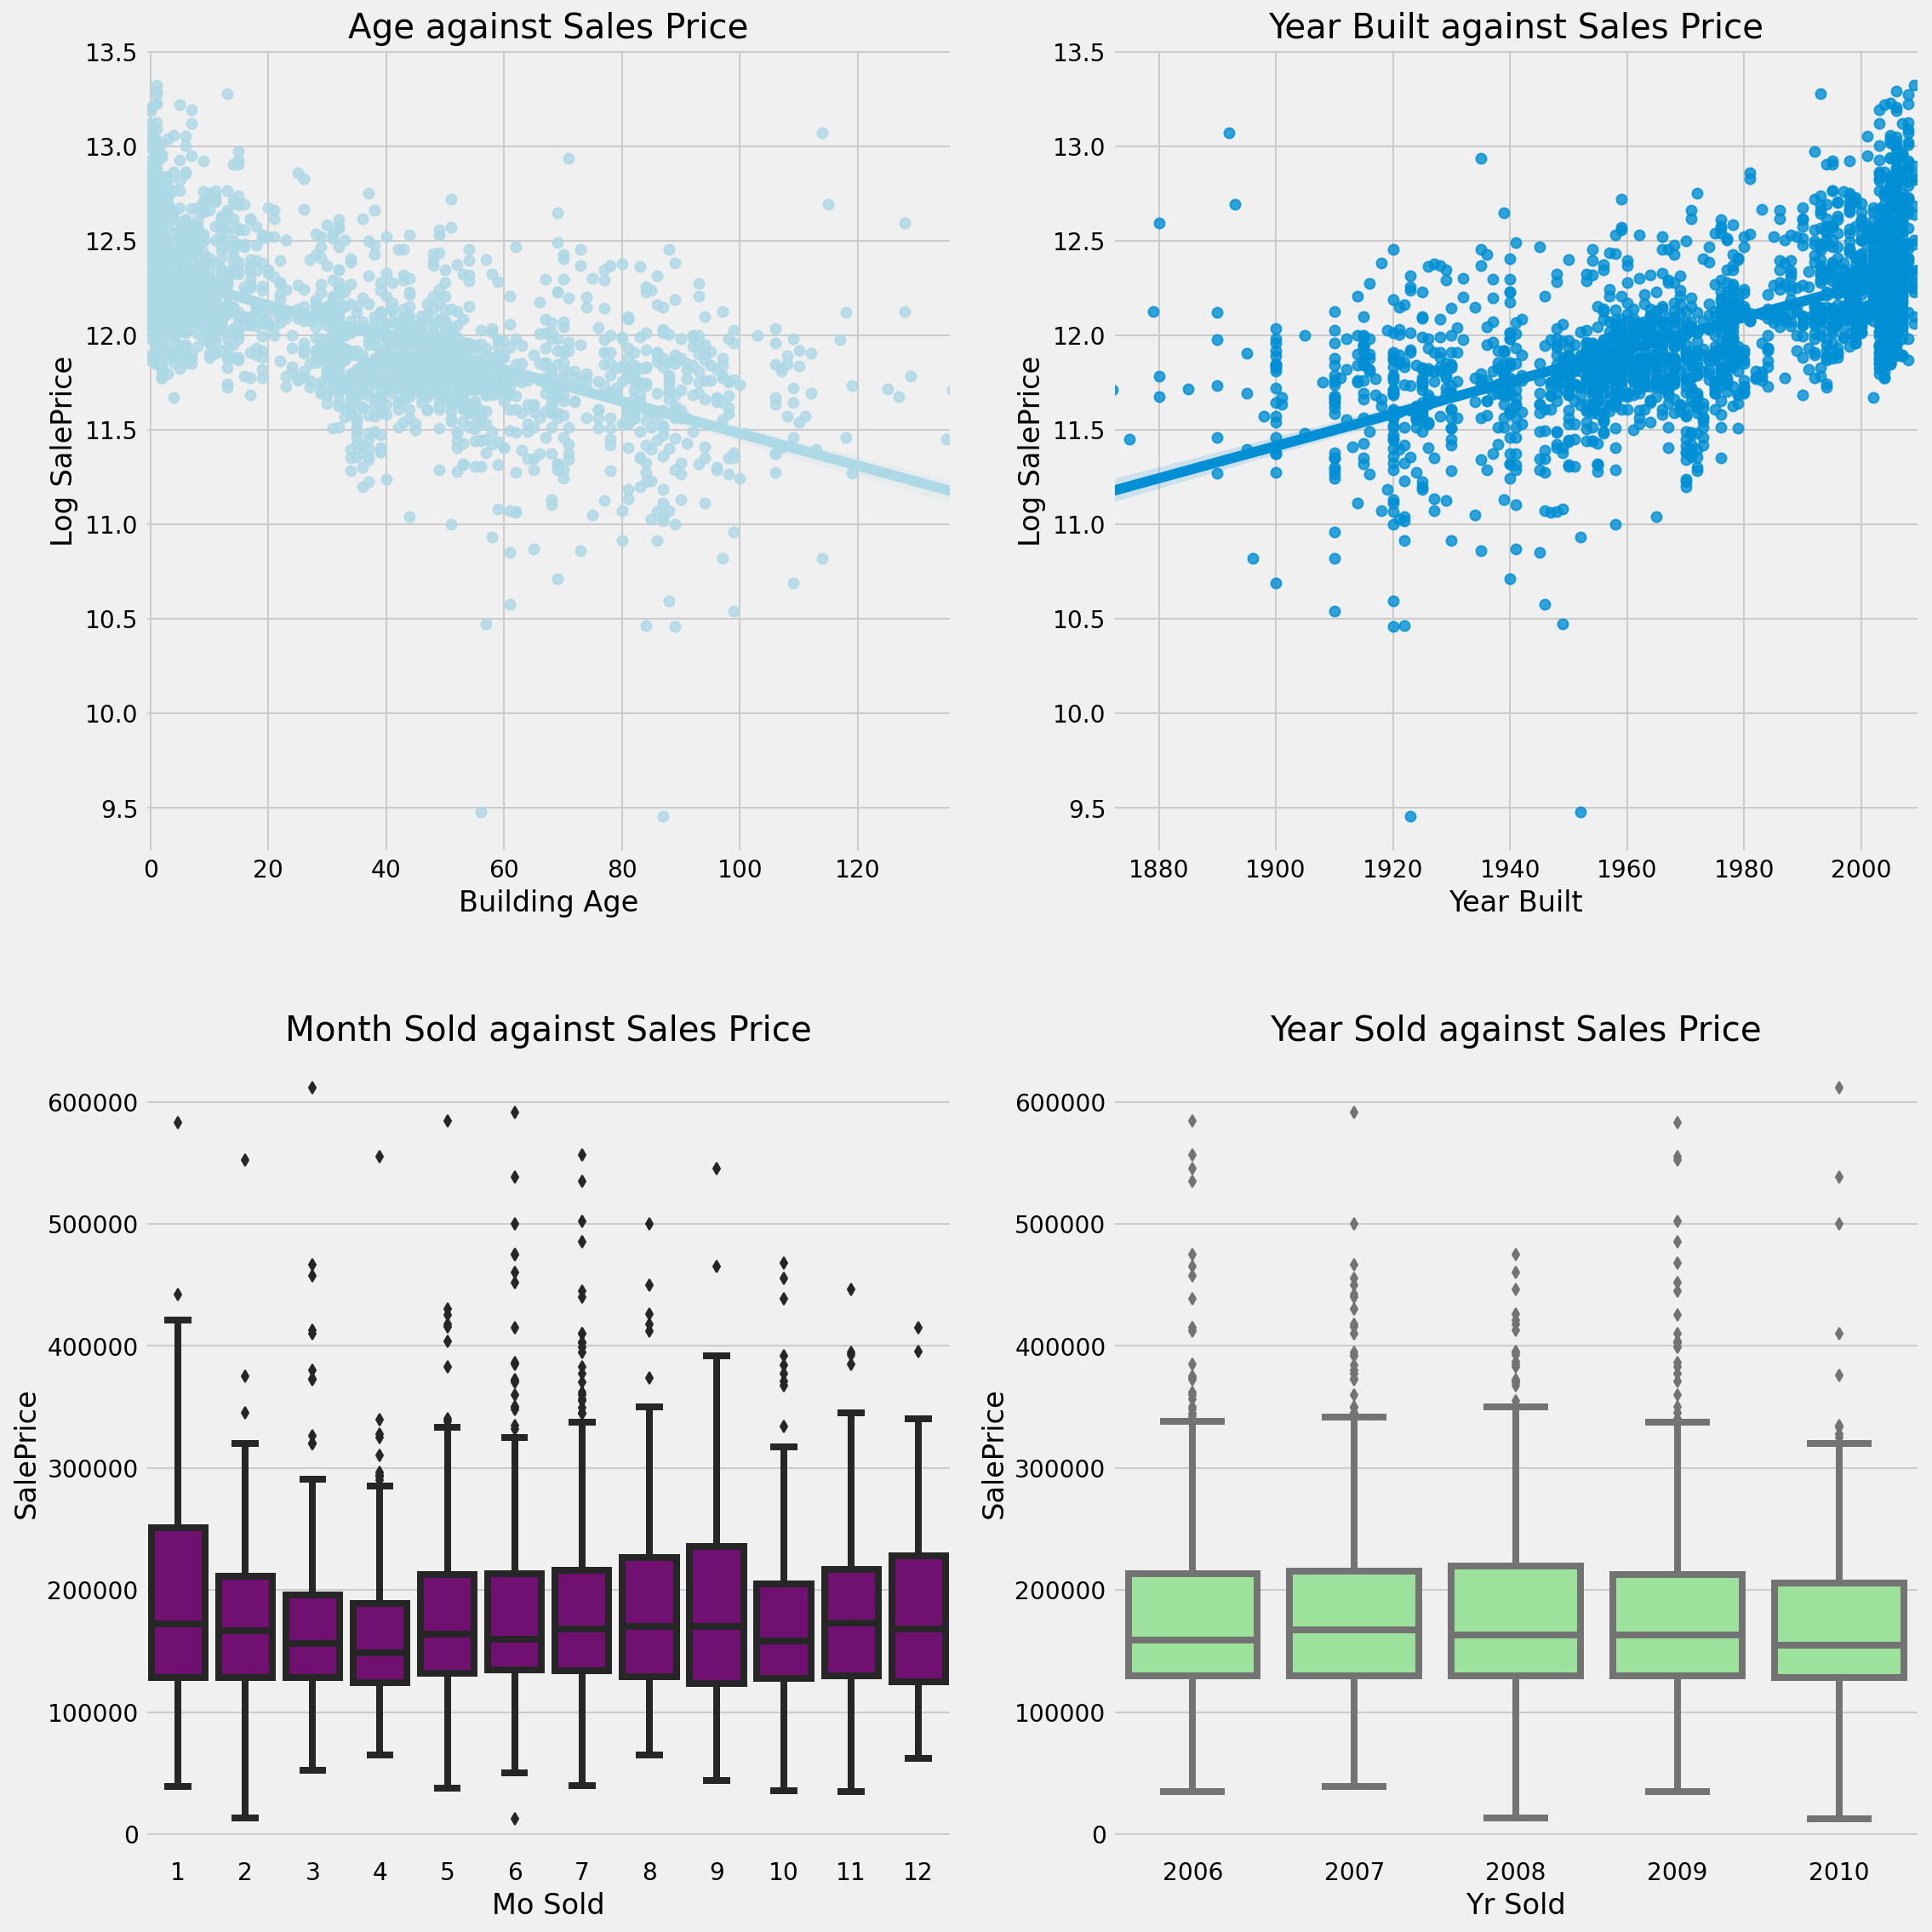

In [18]:
plt.figure(figsize = (16,16))

for i in range(len(df_train)):
    if df_train['Year Remod/Add'][i] > df_train['Year Built'][i]:
        
        df_train['Building Age'] = df_train['Yr Sold'] -  df_train['Year Remod/Add']
    else:
        
        df_train['Building Age'] = df_train['Yr Sold'] -  df_train['Year Built']    

# Plot 1 : Age against Sales Price
plt.subplot(2,2,1)
sns.regplot(data = df_train,
            x = 'Building Age',
            y = 'Log SalePrice',
            color = 'lightblue')
plt.title('Age against Sales Price')

# Plot 2 : year Built against Sales Price
plt.subplot(2,2,2)
sns.regplot(data = df_train,
            x = 'Year Built',
            y = 'Log SalePrice')
plt.title('Year Built against Sales Price')


# Plot 3 : Month Sold against Sales Price
plt.subplot(2,2,3)
sns.boxplot(data = df_train,
            x = 'Mo Sold',
            y = 'SalePrice',
            color = 'purple');
plt.title('Month Sold against Sales Price')


# Plot 3 : Year Sold against Sales Price
plt.subplot(2,2,4)
sns.boxplot(data = df_train,
            x = 'Yr Sold',
            y = 'SalePrice',
            color = 'lightgreen')
plt.title('Year Sold against Sales Price')

plt.tight_layout(h_pad = 4)

### 1.4b General Overview on Basement Features
___

- Total 11 features for Basement : 
    - 6 numeric features : [BsmtFin SF 1, BsmtFin SF 2 , Bsmt Unf SF , Total Bsmt SF , Bsmt Full Bath , Bsmt Half Bath]
    - 4 non-numeric ordinal features : ['Bsmt Qual', 'Bsmt Cond' , 'BsmtFin Type 1' , 'BsmtFin Type 2']
    - 1 non-numeric , non-ordinal features : ['Bsmt Exposure']
- Excellent and Good Bsmt quality typically fetch a higher price.
- Random outliers observed in Total Bsmt SF , BSMT

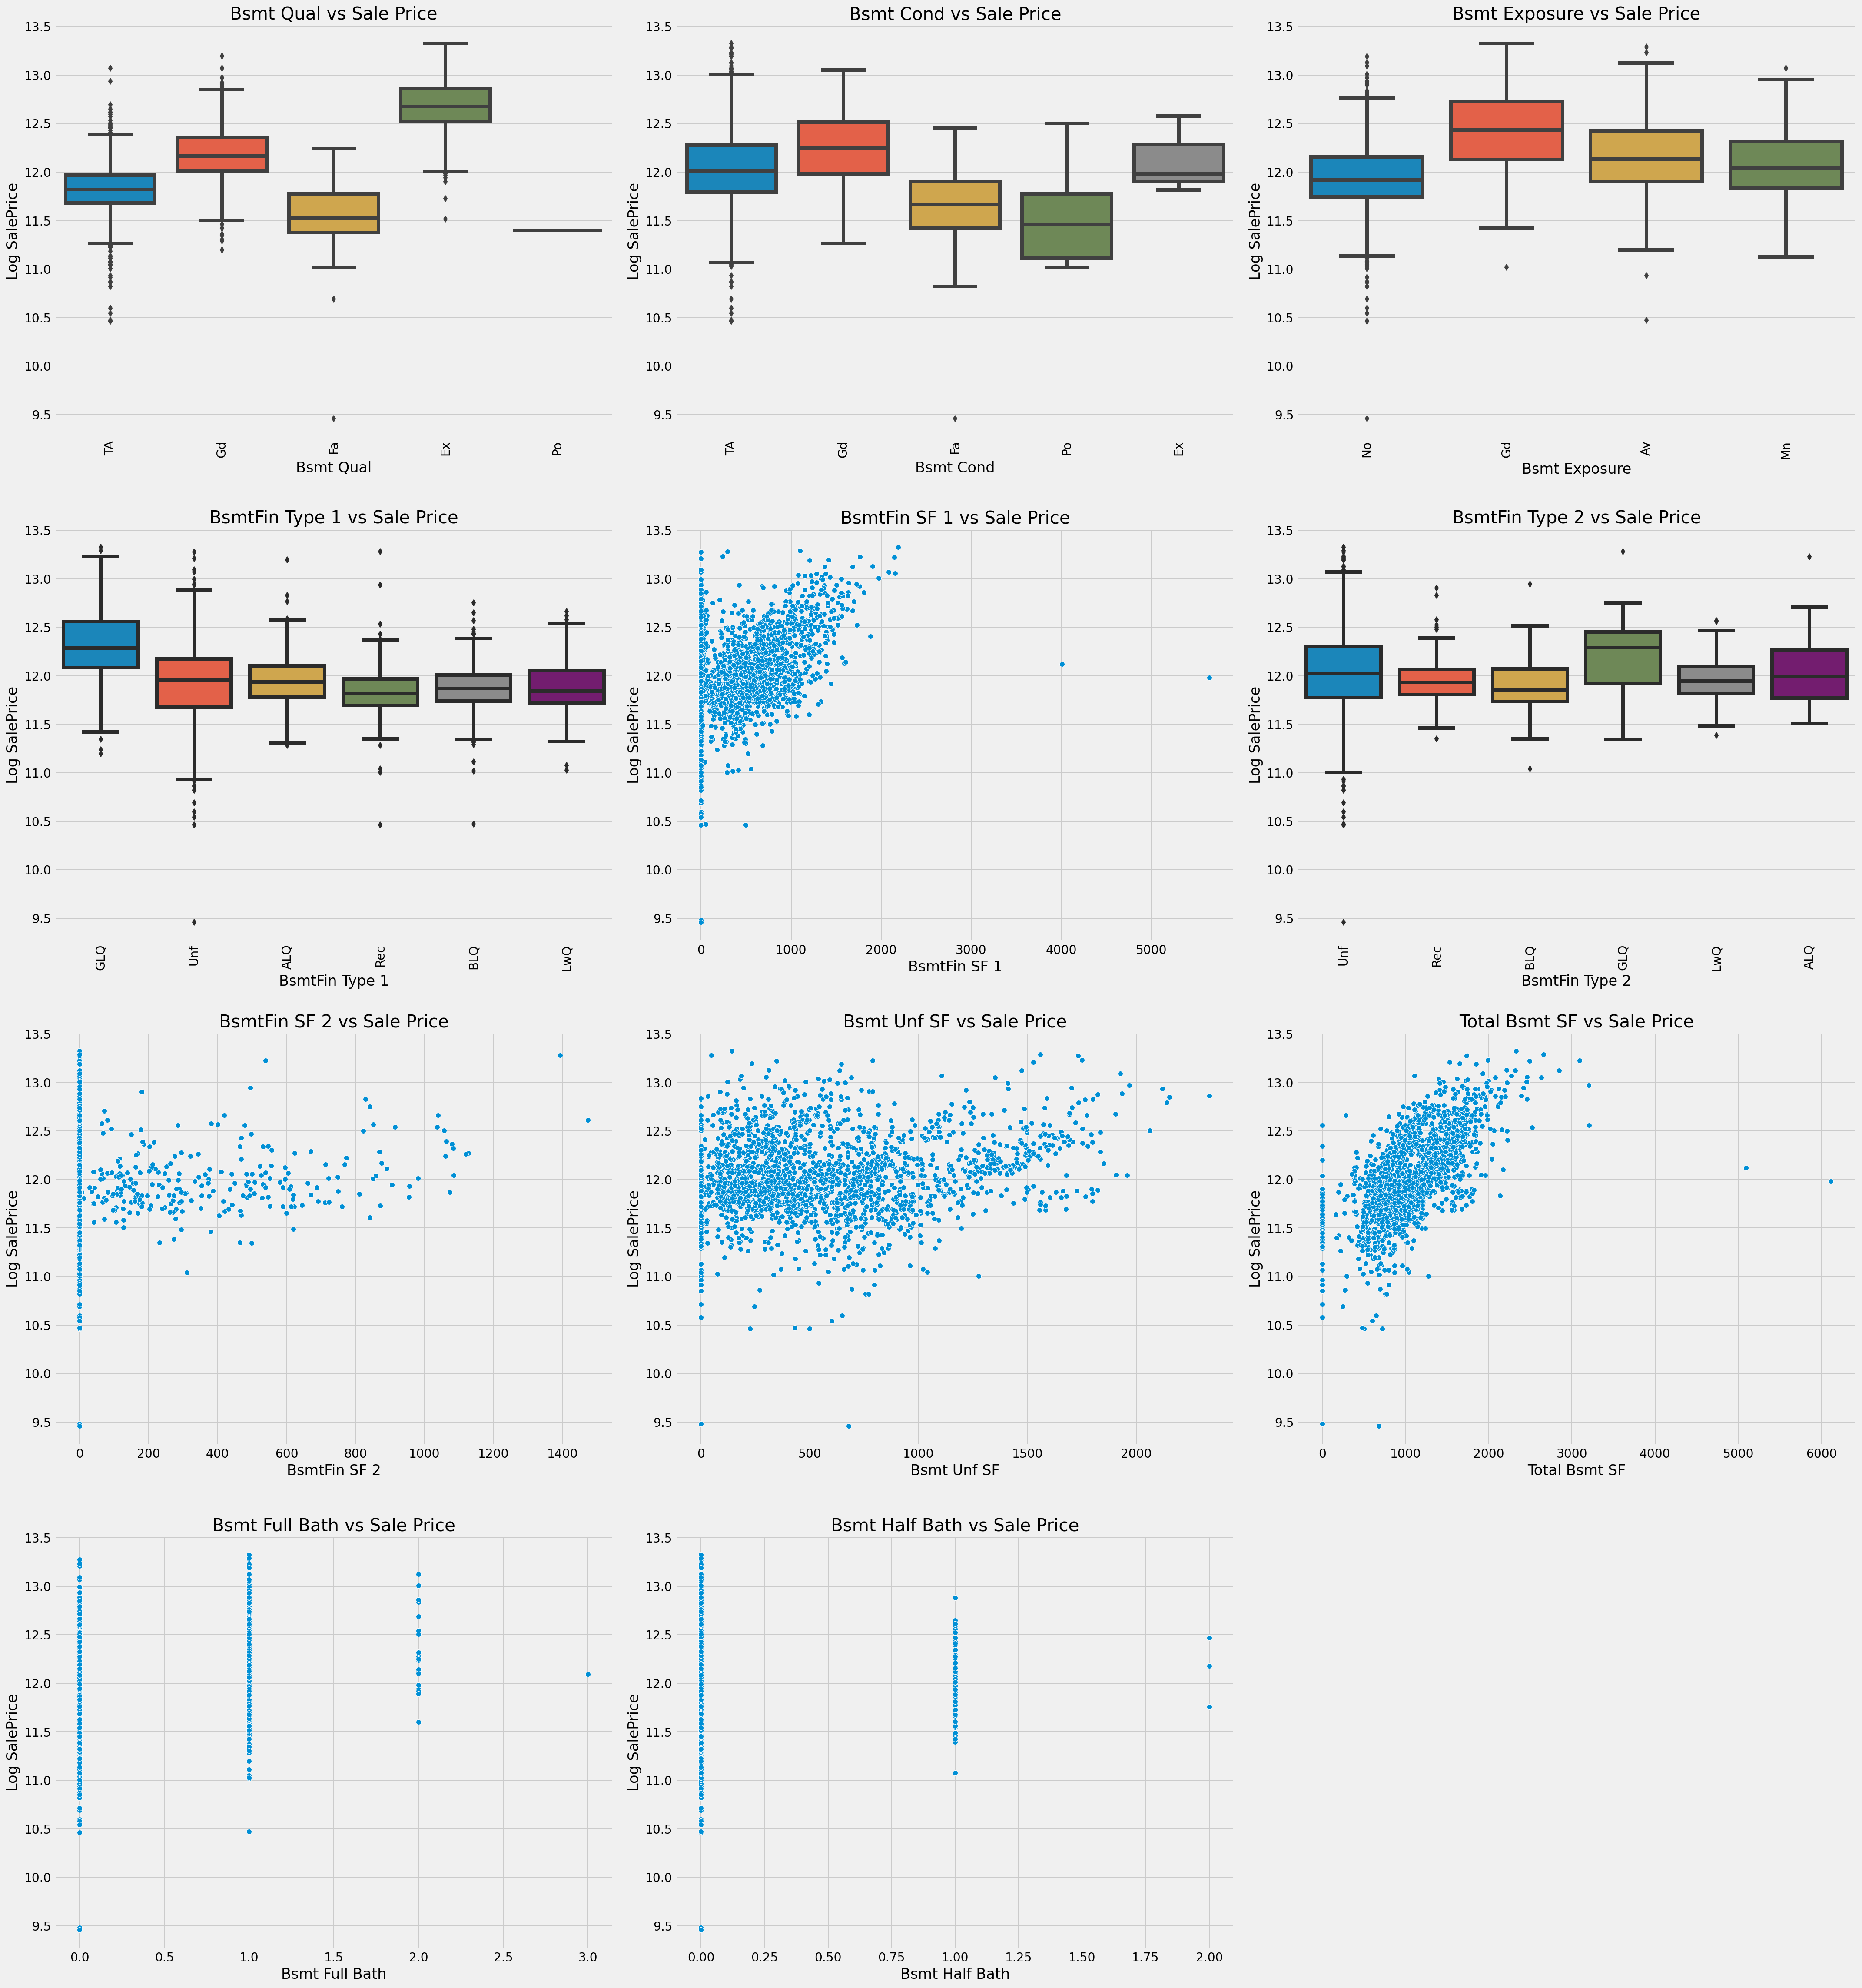

In [19]:
basement_list = [bsmt for bsmt in df_train.columns if 'Bsmt' in bsmt]

EDA_subplot(4 , 3 , basement_list , df_train)

### 1.4c General Overview on Garage Features
___

- Total 8 features for Basement : 
    - 3 numeric features : [Garage Yr Built , Garage Cars , Garage Area]
    - 4 non-numeric ordinal features : [Garage Quality , Garage Cond , Paved Drive , Garage Finish]
    - 1 non-numeric , non-ordinal features : [Garage Type]
- On a quick observation :
    - Quality and condition of Garage does not highly impact sales price. A typically average Garage can fetch higher then an excellent/good Garage.
    - Garage Area doesn't affect the sales price as much too. An average size Garage has a similiar price range as those of a high agrage area.
- Outlier observed in Garage Year Built. Someone had travalled into the future and build a garage 200 year in advance.
- Col Name annotation appear not to be consistent for same meaning : QC , QU , Qual , Cond. All same meaning , but different name.

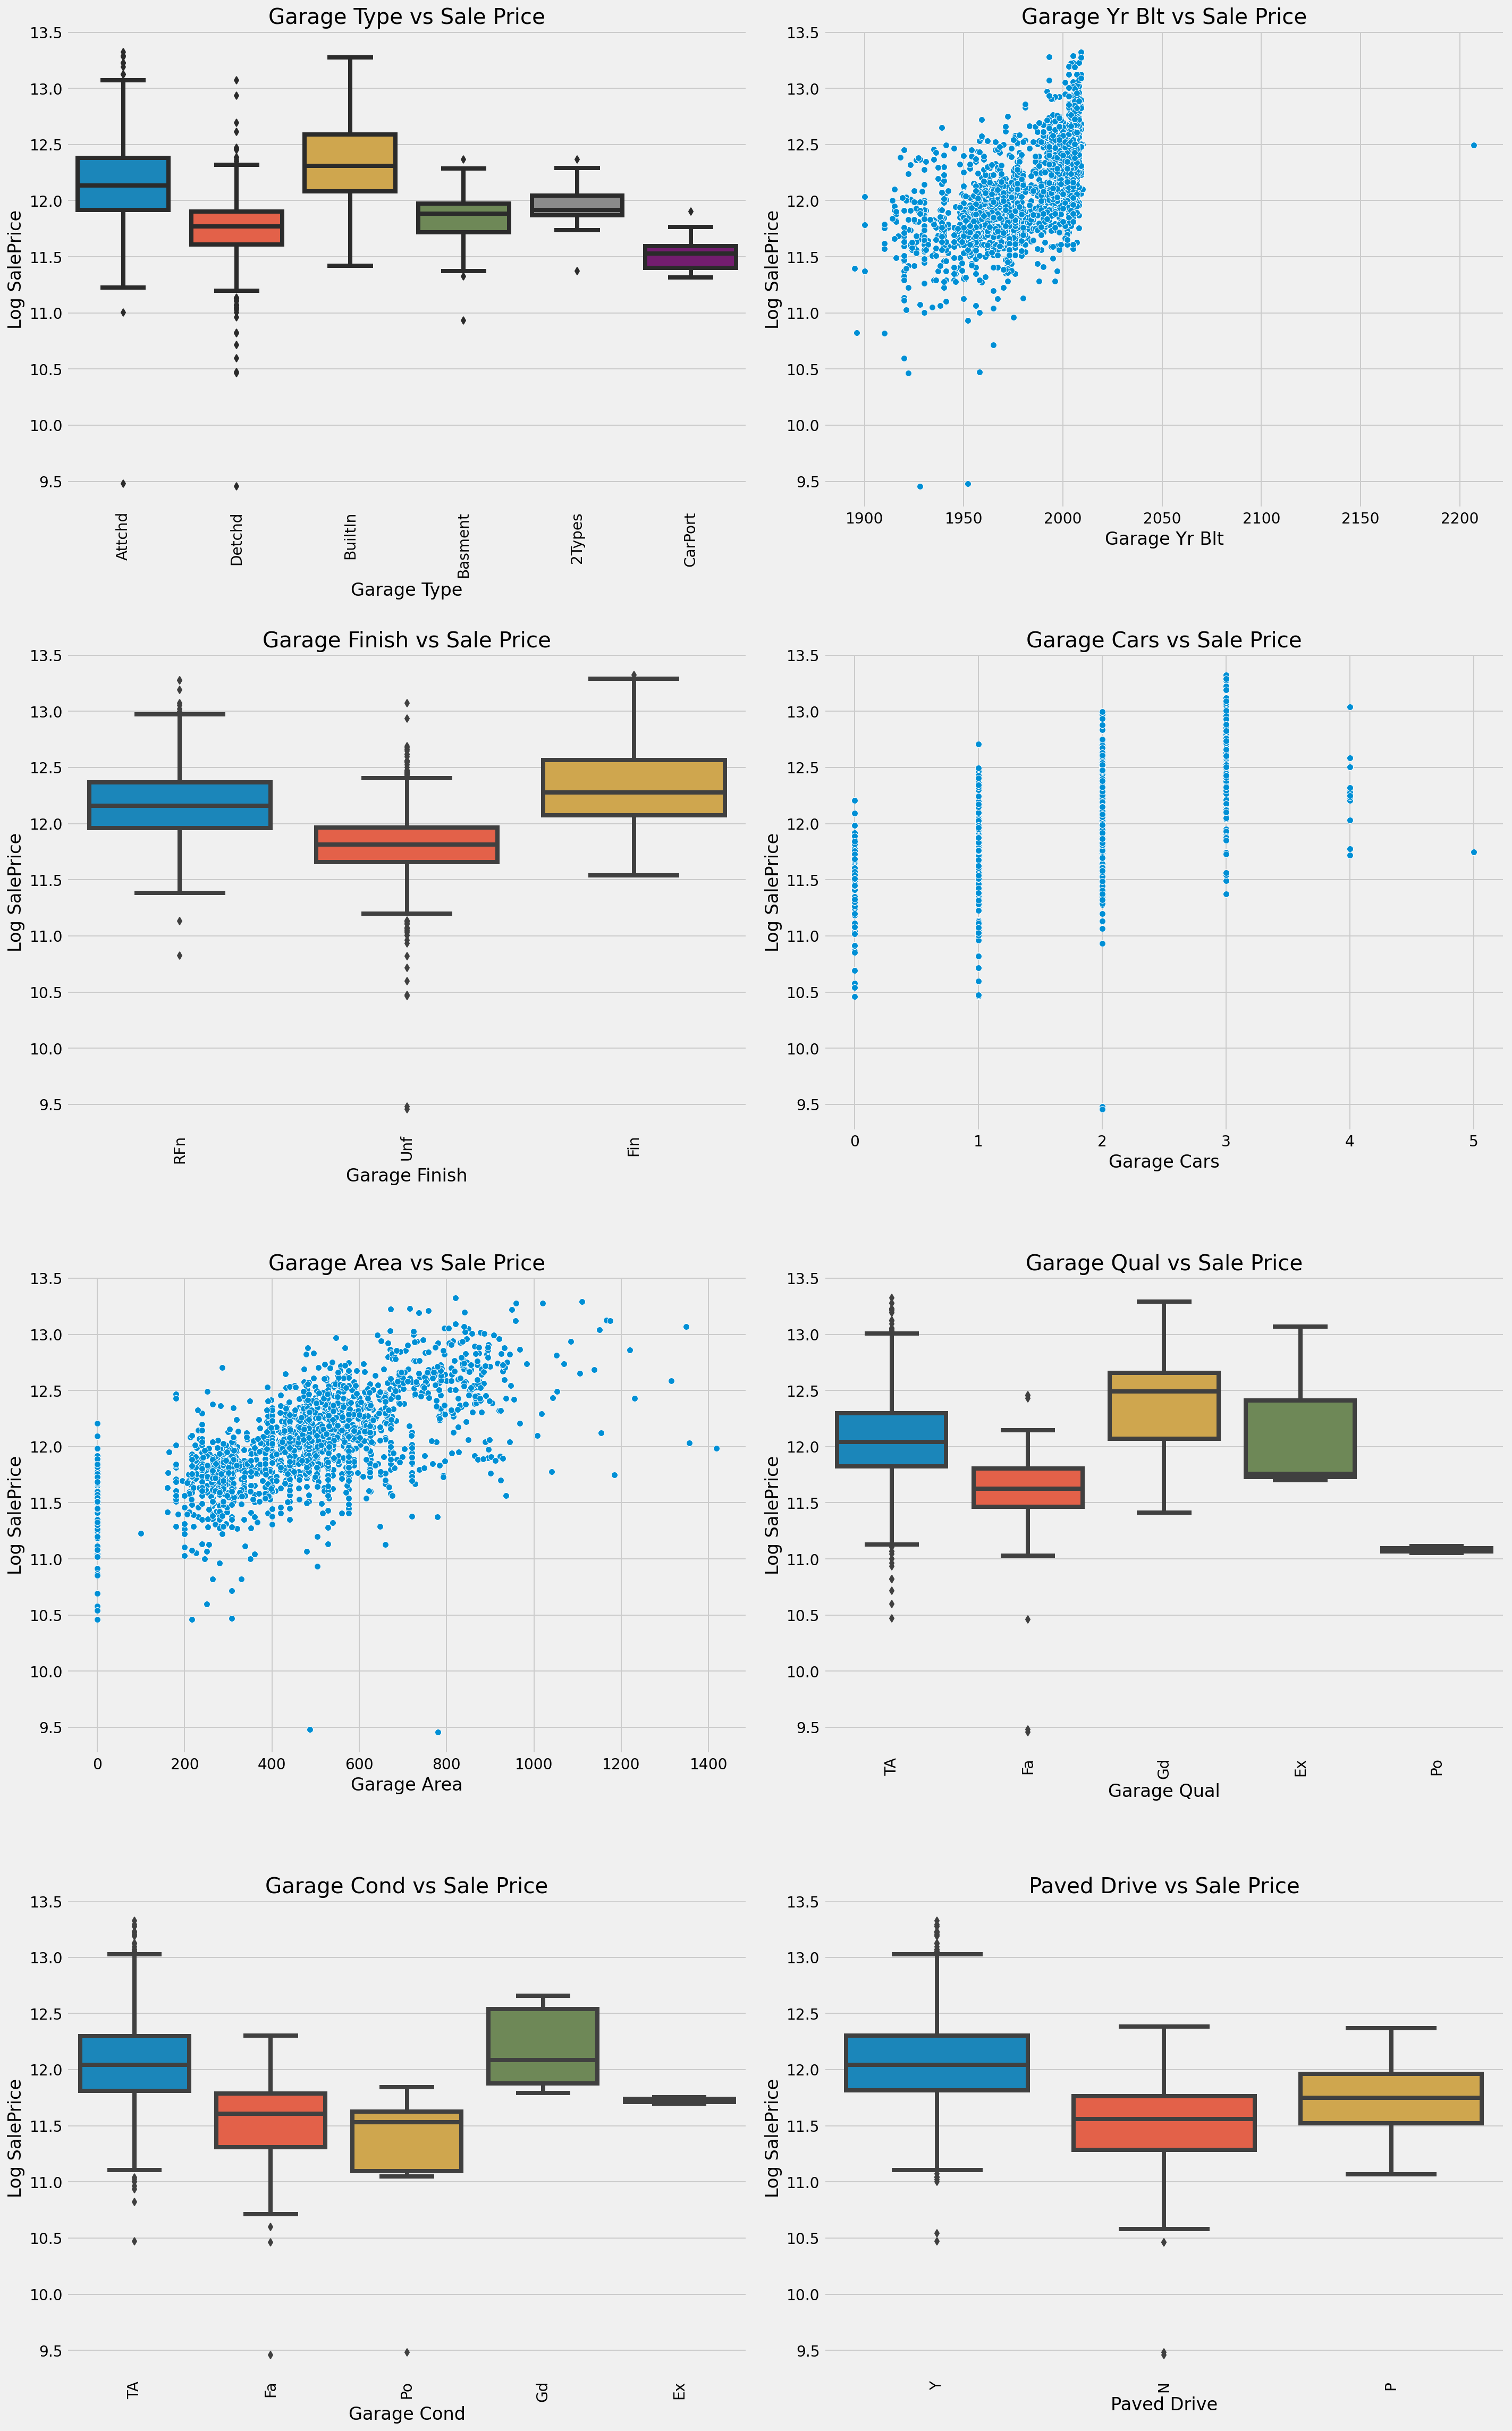

In [20]:
garage_list  = [garage for garage in df_train if 'Garage' in garage or 'Paved' in garage]
EDA_subplot(4 , 2 , garage_list , df_train)

### 1.4d General Overview on Heating & Utilities Related
___
- Total **4** features for Heater : 
    - 1 numeric features : [Fireplaces]
    - 4 non-numeric ordinal features : [Heating QC , Fireplace QU , Electrical , Utilities]
    - 2 non-numeric , non-ordinal features : [Heating , Central Air]
- Having excellent & good heating facilities and fireplaces indicate a better selling price.
- Having Air conditioning helps in saleprice too.
- Most houses utilises the standard CCB
- Gas Heating is more common than gravity furnance and wall furnance
- Col Name annotation appear not to be consistent for same meaning : QC , QU , Qual , Cond. All same meaning , but different name.

| Features     | Type        | Description                                                                                                                                                                                            |
|--------------|-------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Heating      | Categorical | Floor : Floor Furnance<br>GasA : Gas Forced warm air furnance<br>GasW : Gas hot water or steam heat<br>Grav : Gravity Furnance<br>Wall : Wall Furnance                                                 |
| Heating QC   | Ordinal     | Ex : Excellent<br>Gd : Good<br>TA : Typical Average<br>Fa : Fair<br>Po : Poor                                                                                                                          |
| Fireplaces   | Discrete    | Number of fireplaces                                                                                                                                                                                   |
| Fireplace Qu | Ordinal     | Ex : Excellent<br>Gd : Good<br>TA : Typical Average<br>Fa : Fair<br>Po : Poor<br>NA : No Fireplace                                                                                                     |
| Central Air  | Categorical | Central air conditioning (Yes /No)                                                                                                                                                                     |
| Electrical   | Ordinal     | Electrical system<br>SBrkr : Standard CCB<br>FuseA : Fuse Box over 60A with all Romex Wiring<br>FuseF : Fuse Box at 60A with mostly Romex wiring<br>FuseP : Fuse Box at 60A with tube wiring<br>Mixed  |
| Utilities    | Ordinal     | Type of utilities available<br>AllPub : E , G , W , S<br>NoSewr : E , G , W<br>NoSeWa : E , G<br>ELO : E                                                                                               |                                                    |

<Figure size 864x864 with 0 Axes>

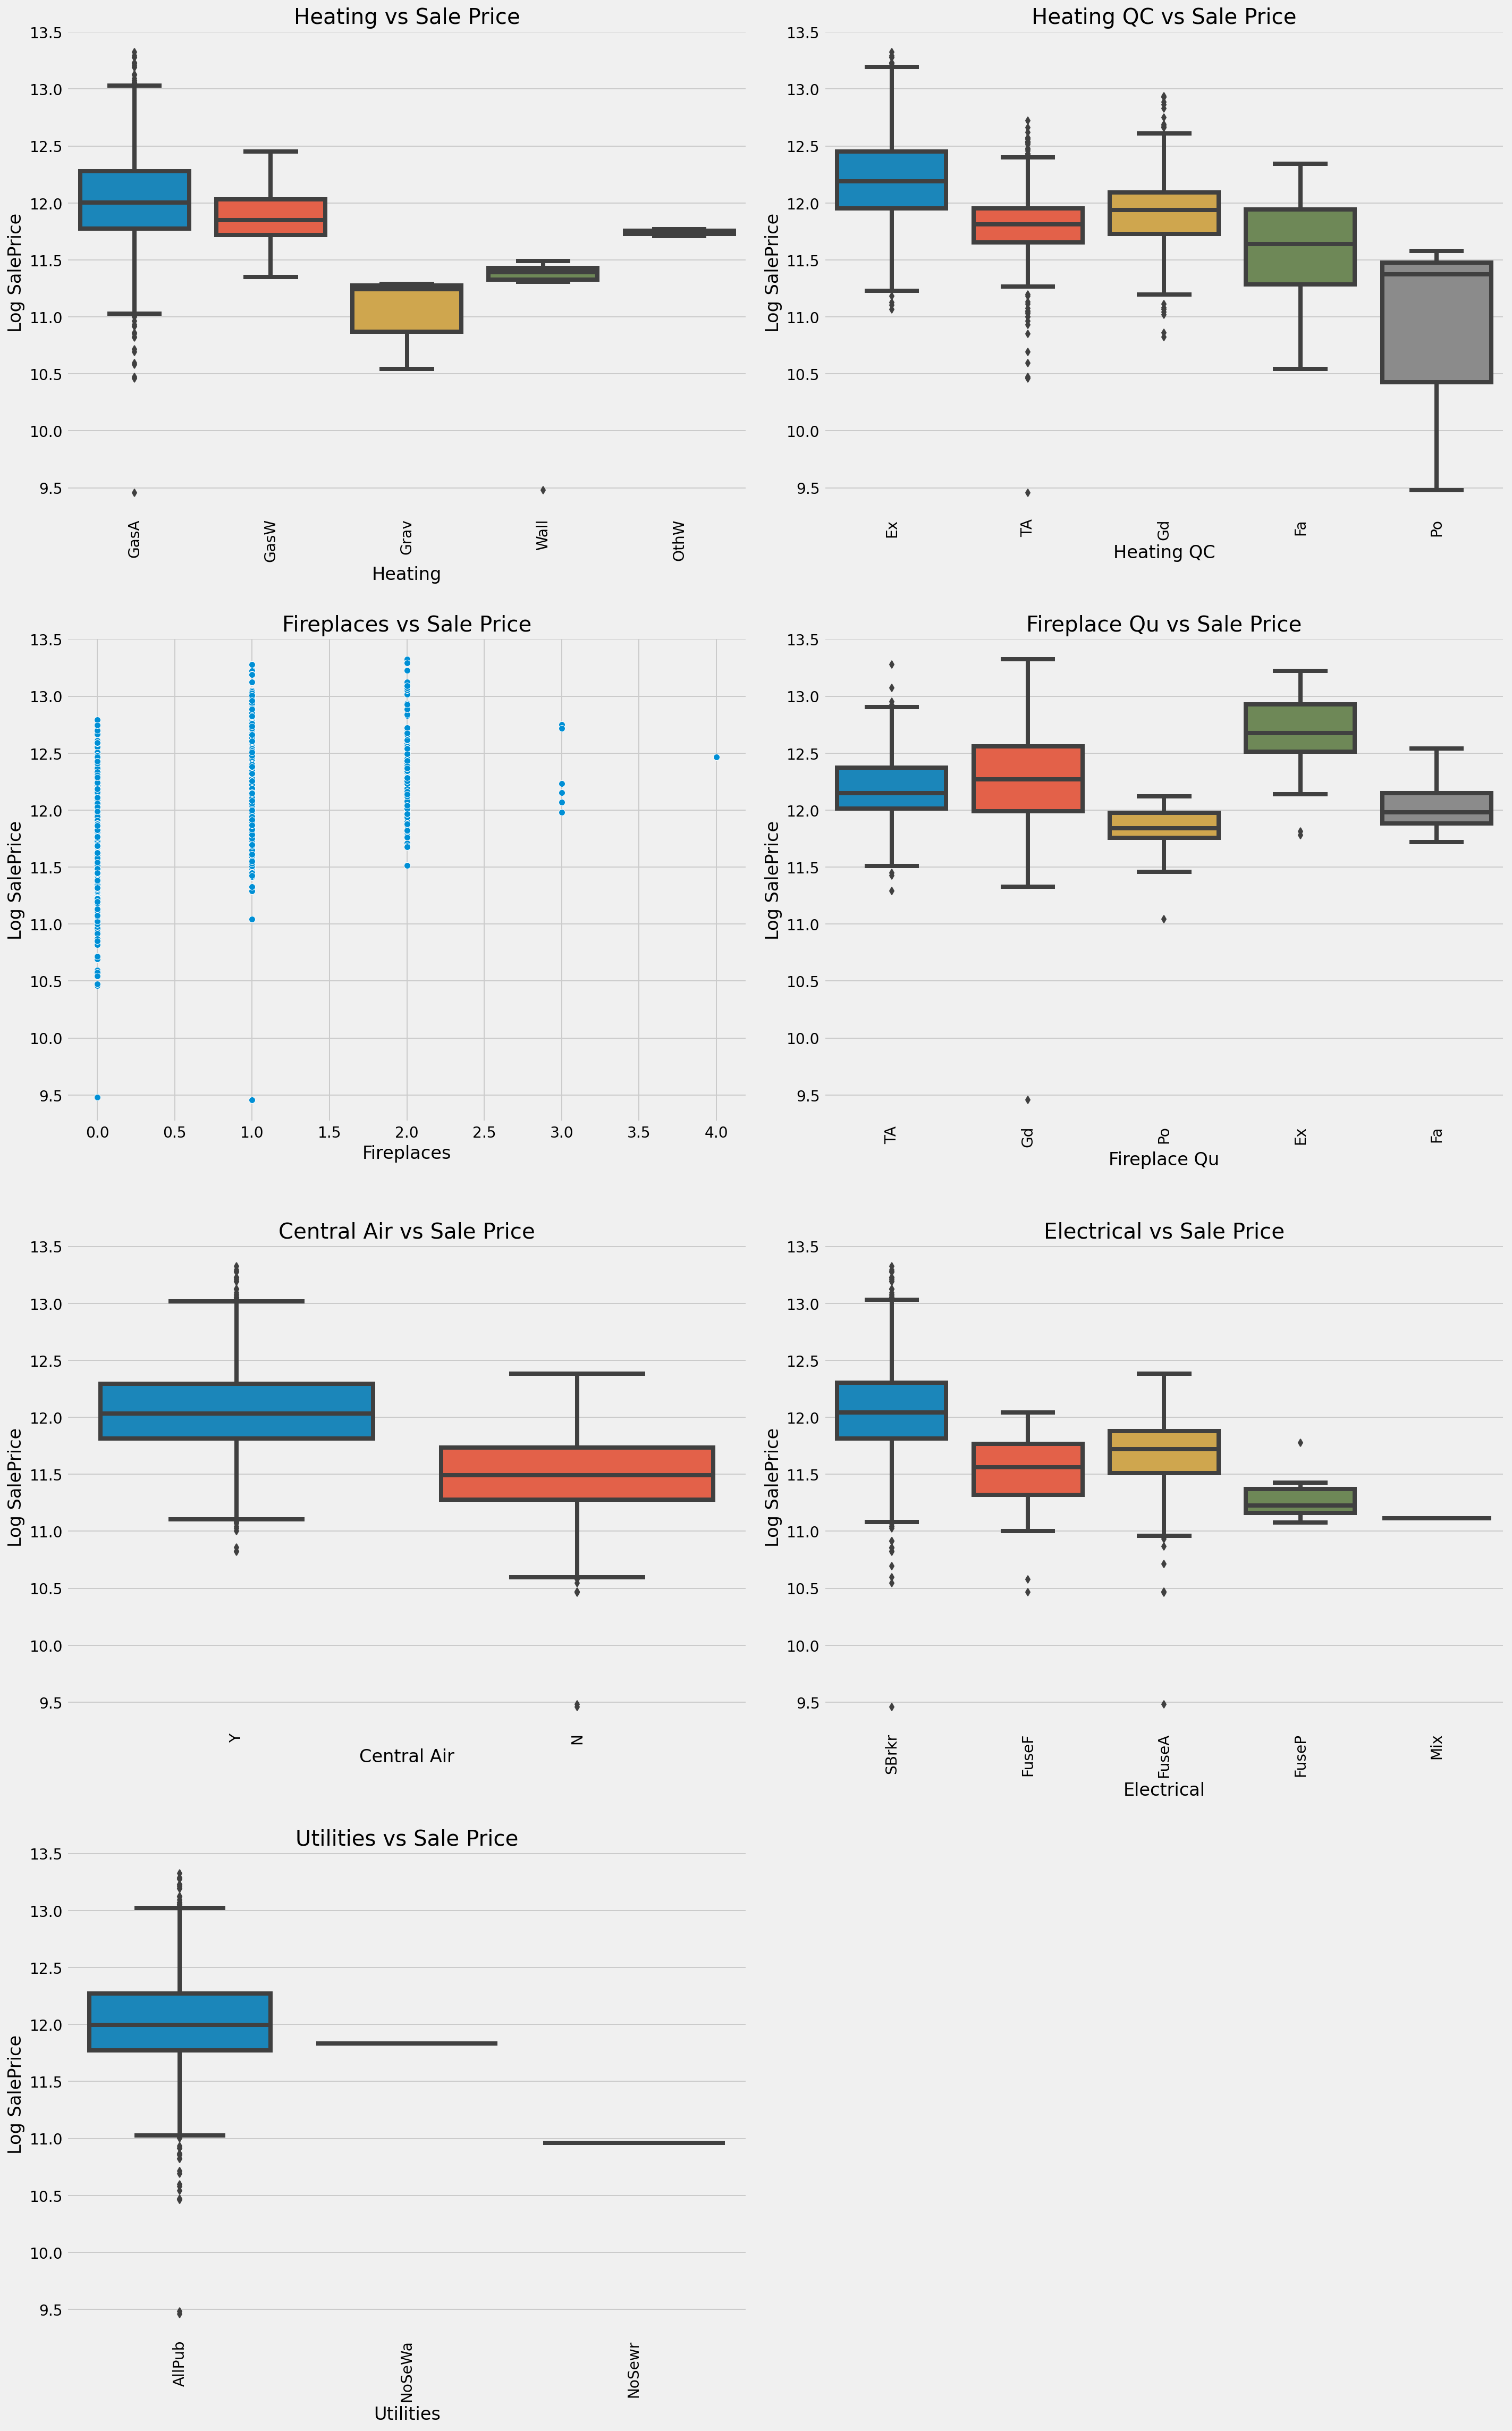

In [21]:
utilities_list  = ['Heating' , 'Heating QC' , 'Fireplaces' , 'Fireplace Qu' , 'Central Air' ,'Electrical' , 'Utilities']
utilities_list

plt.figure(figsize = (12,12))
EDA_subplot(4 , 2 , utilities_list , df_train);

### 1.4.1d Does Sales Price increase at Winter Season with better quality heating feature?
___

- Sales price with the same excellent , good heating quality remain fairly constant across all season.
- Heater type using Gas is able to fetch a higher price typically.


In [22]:
# Creating a dict for season

season_map = {1 : 'Spring' , 2 : 'Spring' , 3 : 'Spring',
              4 : 'Summer' , 5 : 'Summer' , 6 : 'Summer',
              7 : 'Autumn' , 8 : 'Autumn' , 9 : 'Autumn',
              10 : 'Winter' , 11 : 'Winter' , 12 : 'Winter'}

df_train['Season'] = df_train['Mo Sold'].map(season_map)

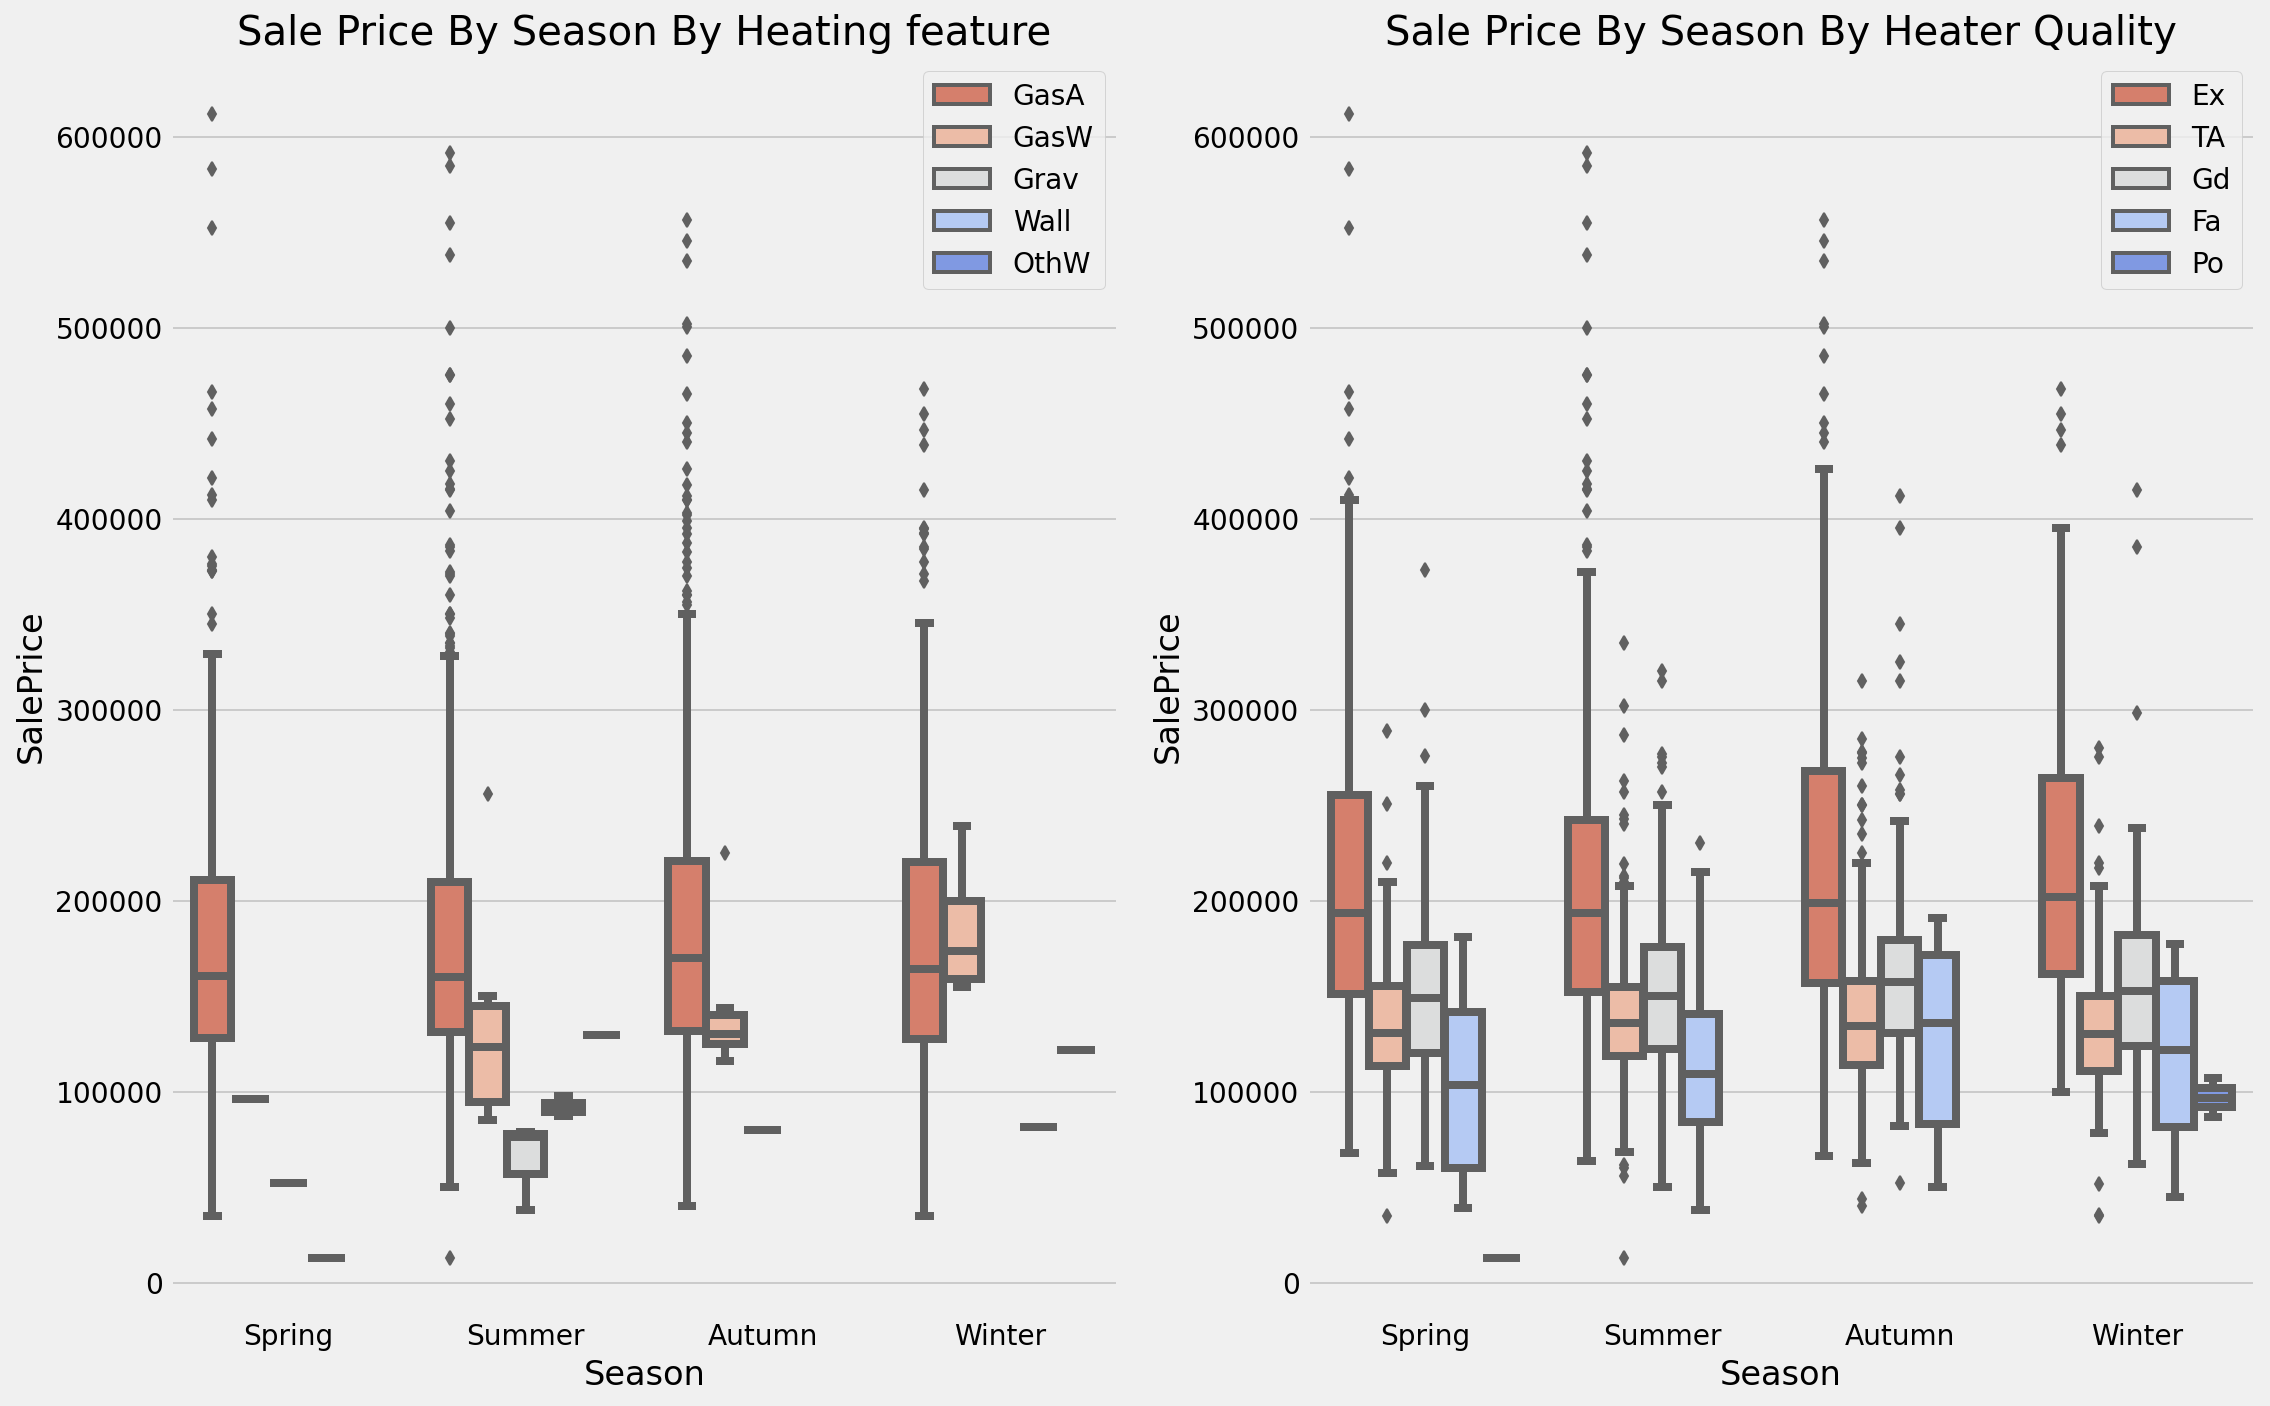

In [23]:
# Plotting Seasons against heating features
plt.figure(figsize = (16,10))

plt.subplot(1,2,1)
sns.boxplot(data = df_train,
            x = 'Season',
            y = 'SalePrice',
            hue = 'Heating',
            palette = 'coolwarm_r');
plt.title('Sale Price By Season By Heating feature')
plt.legend(loc = 'best')

plt.subplot(1,2,2)
sns.boxplot(data = df_train,
            x = 'Season',
            y = 'SalePrice',
            hue = 'Heating QC',
            palette = 'coolwarm_r');
plt.title('Sale Price By Season By Heater Quality')
plt.legend(loc = 'best')

plt.tight_layout()

### 1.4e General Overview on Porch Features
___
- Total **5** features for Porch : 
    - 5 numeric features (All of the 4)
- There are houses with no porch that is selling higher or equivalently as high as those with porch.

| Features       | Type       | Unit  |
|----------------|------------|-------|
| Wood Deck SF   | Continuous | Sq Ft |
| Open Porch SF  | Continuous | Sq Ft |
| Enclosed Porch | Continuous | Sq Ft |
| 3-Ssn Porch    | Continuous | Sq Ft |
| Screen Porch   | Continuous | Sq Ft |

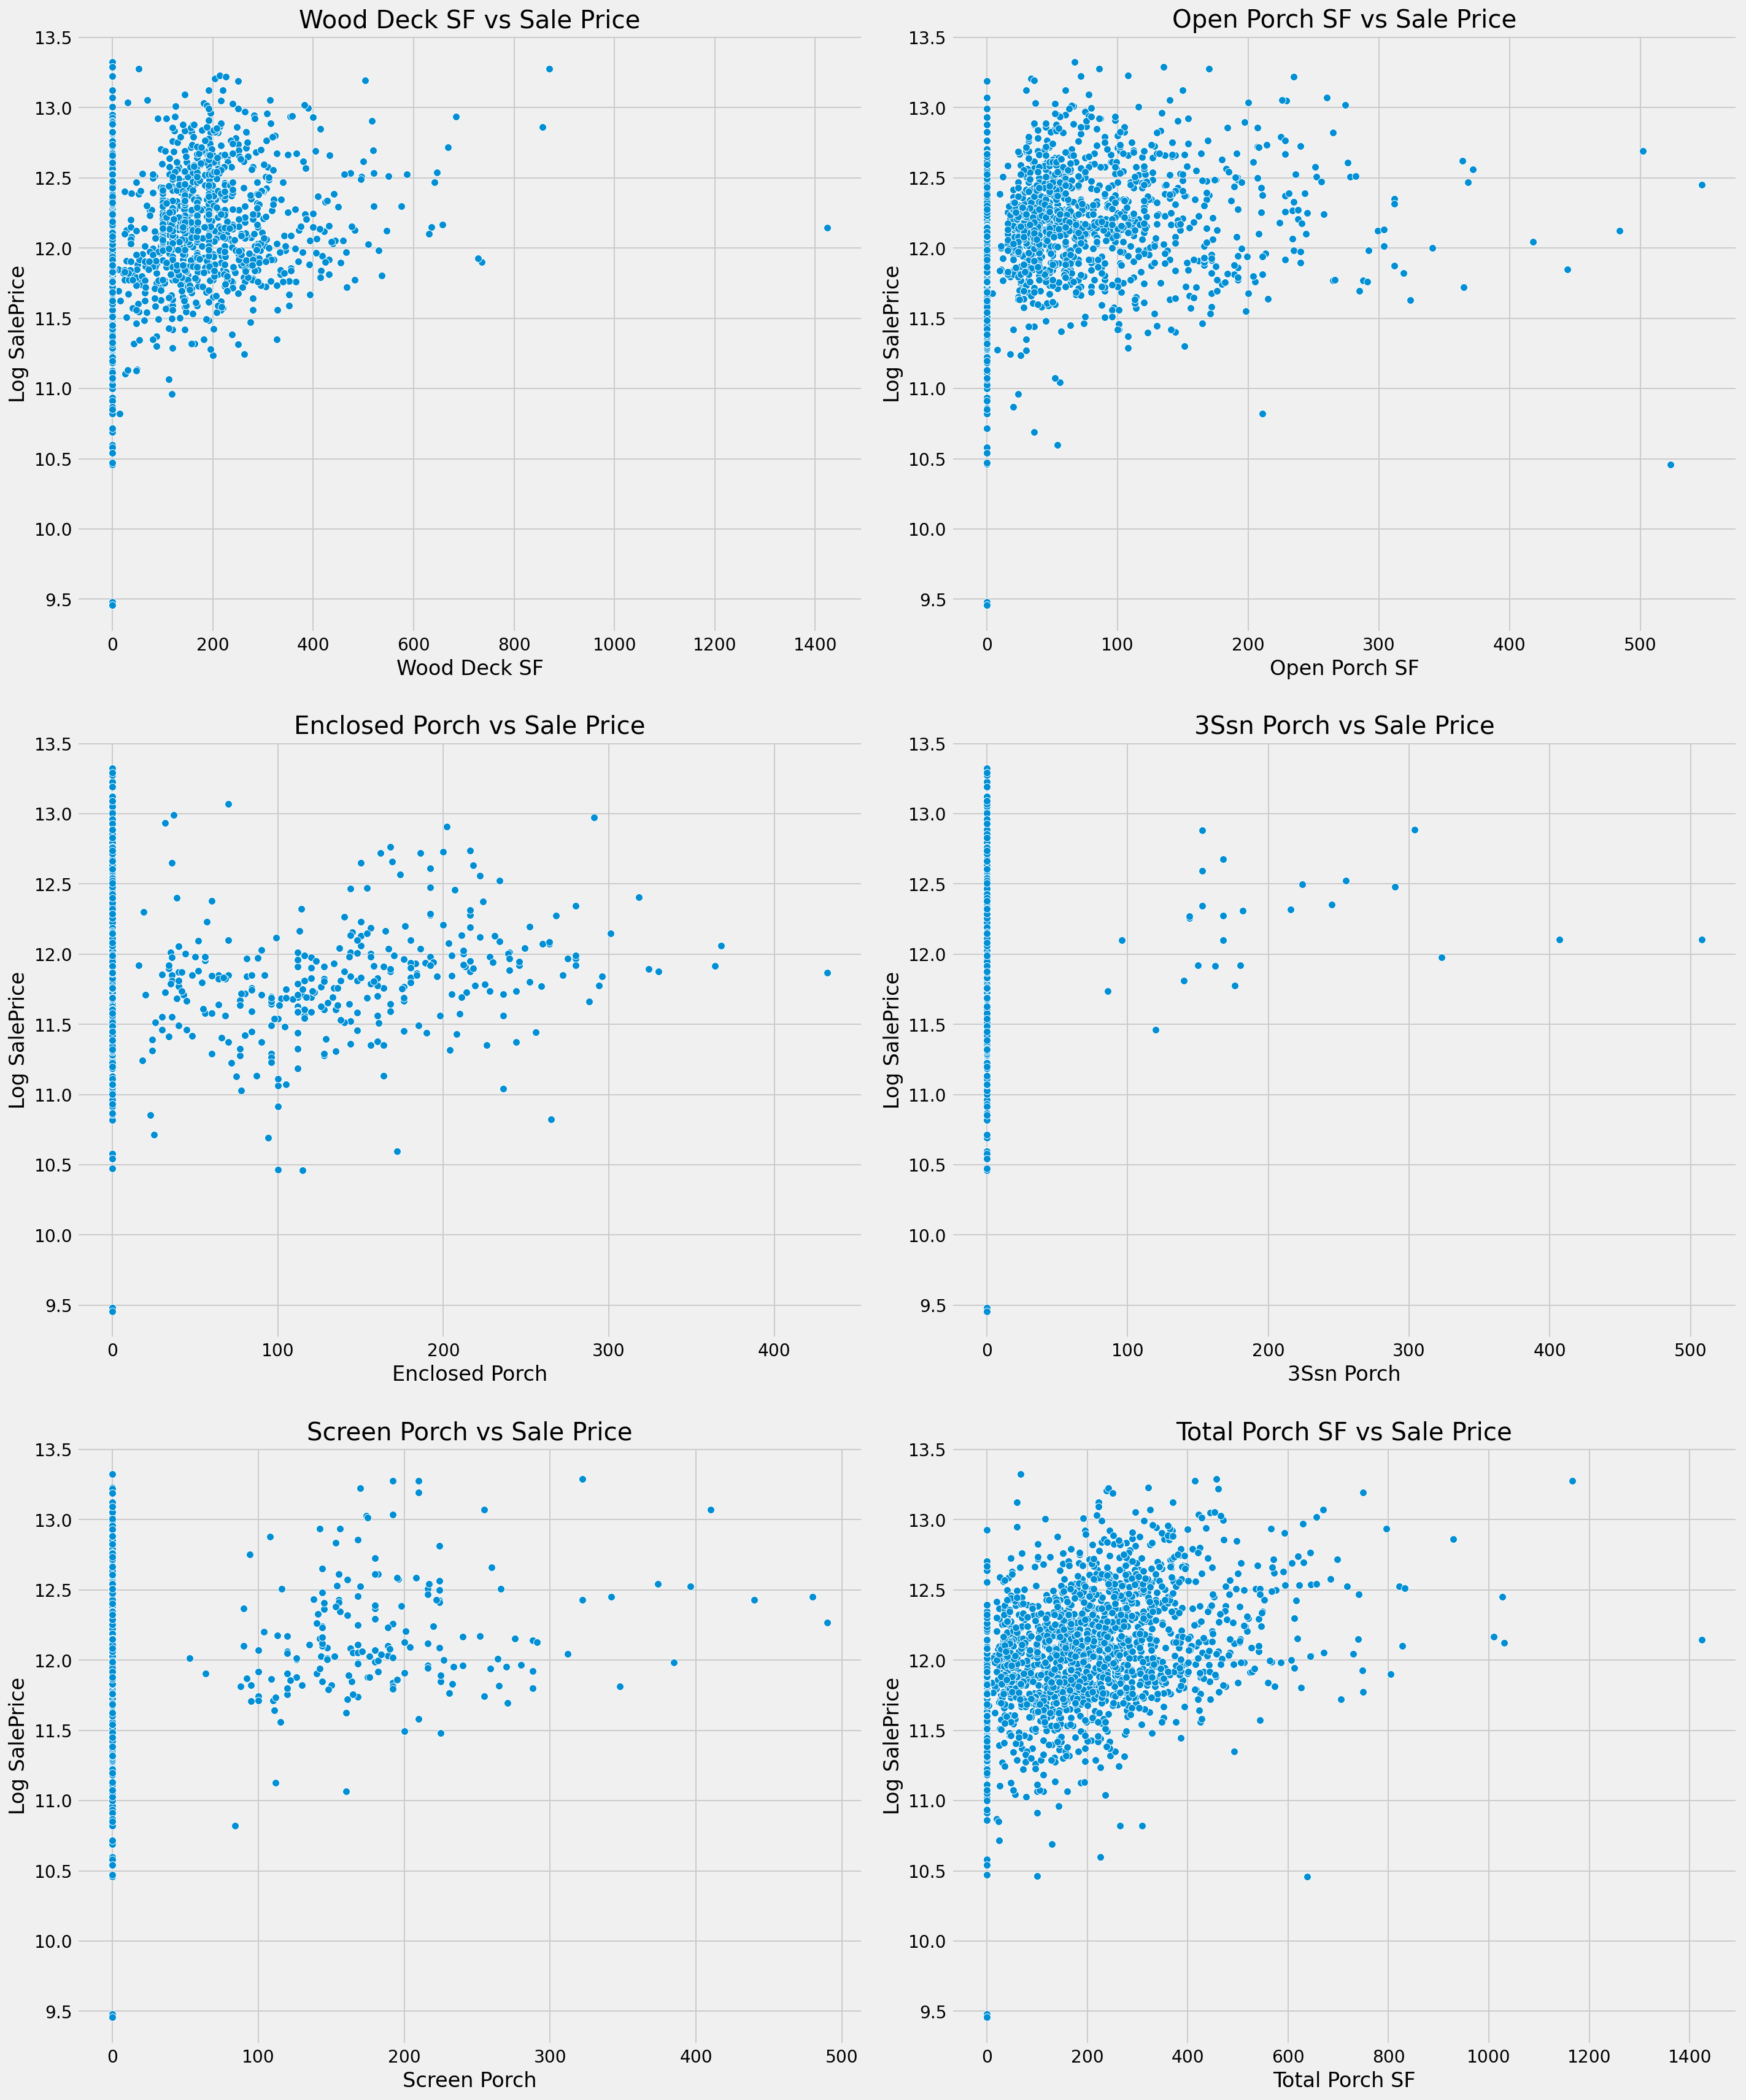

In [24]:
porch_list  = [porch for porch in df_train if 'Porch'in porch or 'Deck' in porch]

df_train['Total Porch SF'] = df_train[porch_list].sum(axis = 1)

porch_list  = [porch for porch in df_train if 'Porch'in porch or 'Deck' in porch]

EDA_subplot(3 , 2 , porch_list , df_train)

### 1.4f General Overview on House Exterior Features
___

- Total **6** features for Heater : 
    - 2 non-numeric ordinal features : [Exter Qual , Exter Cond]
    - 4 non-numeric , non-ordinal features : [Exterior 1st , Exterior 2nd , Roof Style , Roof Matl]
- Having excellent housing condition correlate to a higher price and a poor 
- Gas Heating is more common than gravity furnance and wall furnance
- Outlier Data can be observed in Exterior features

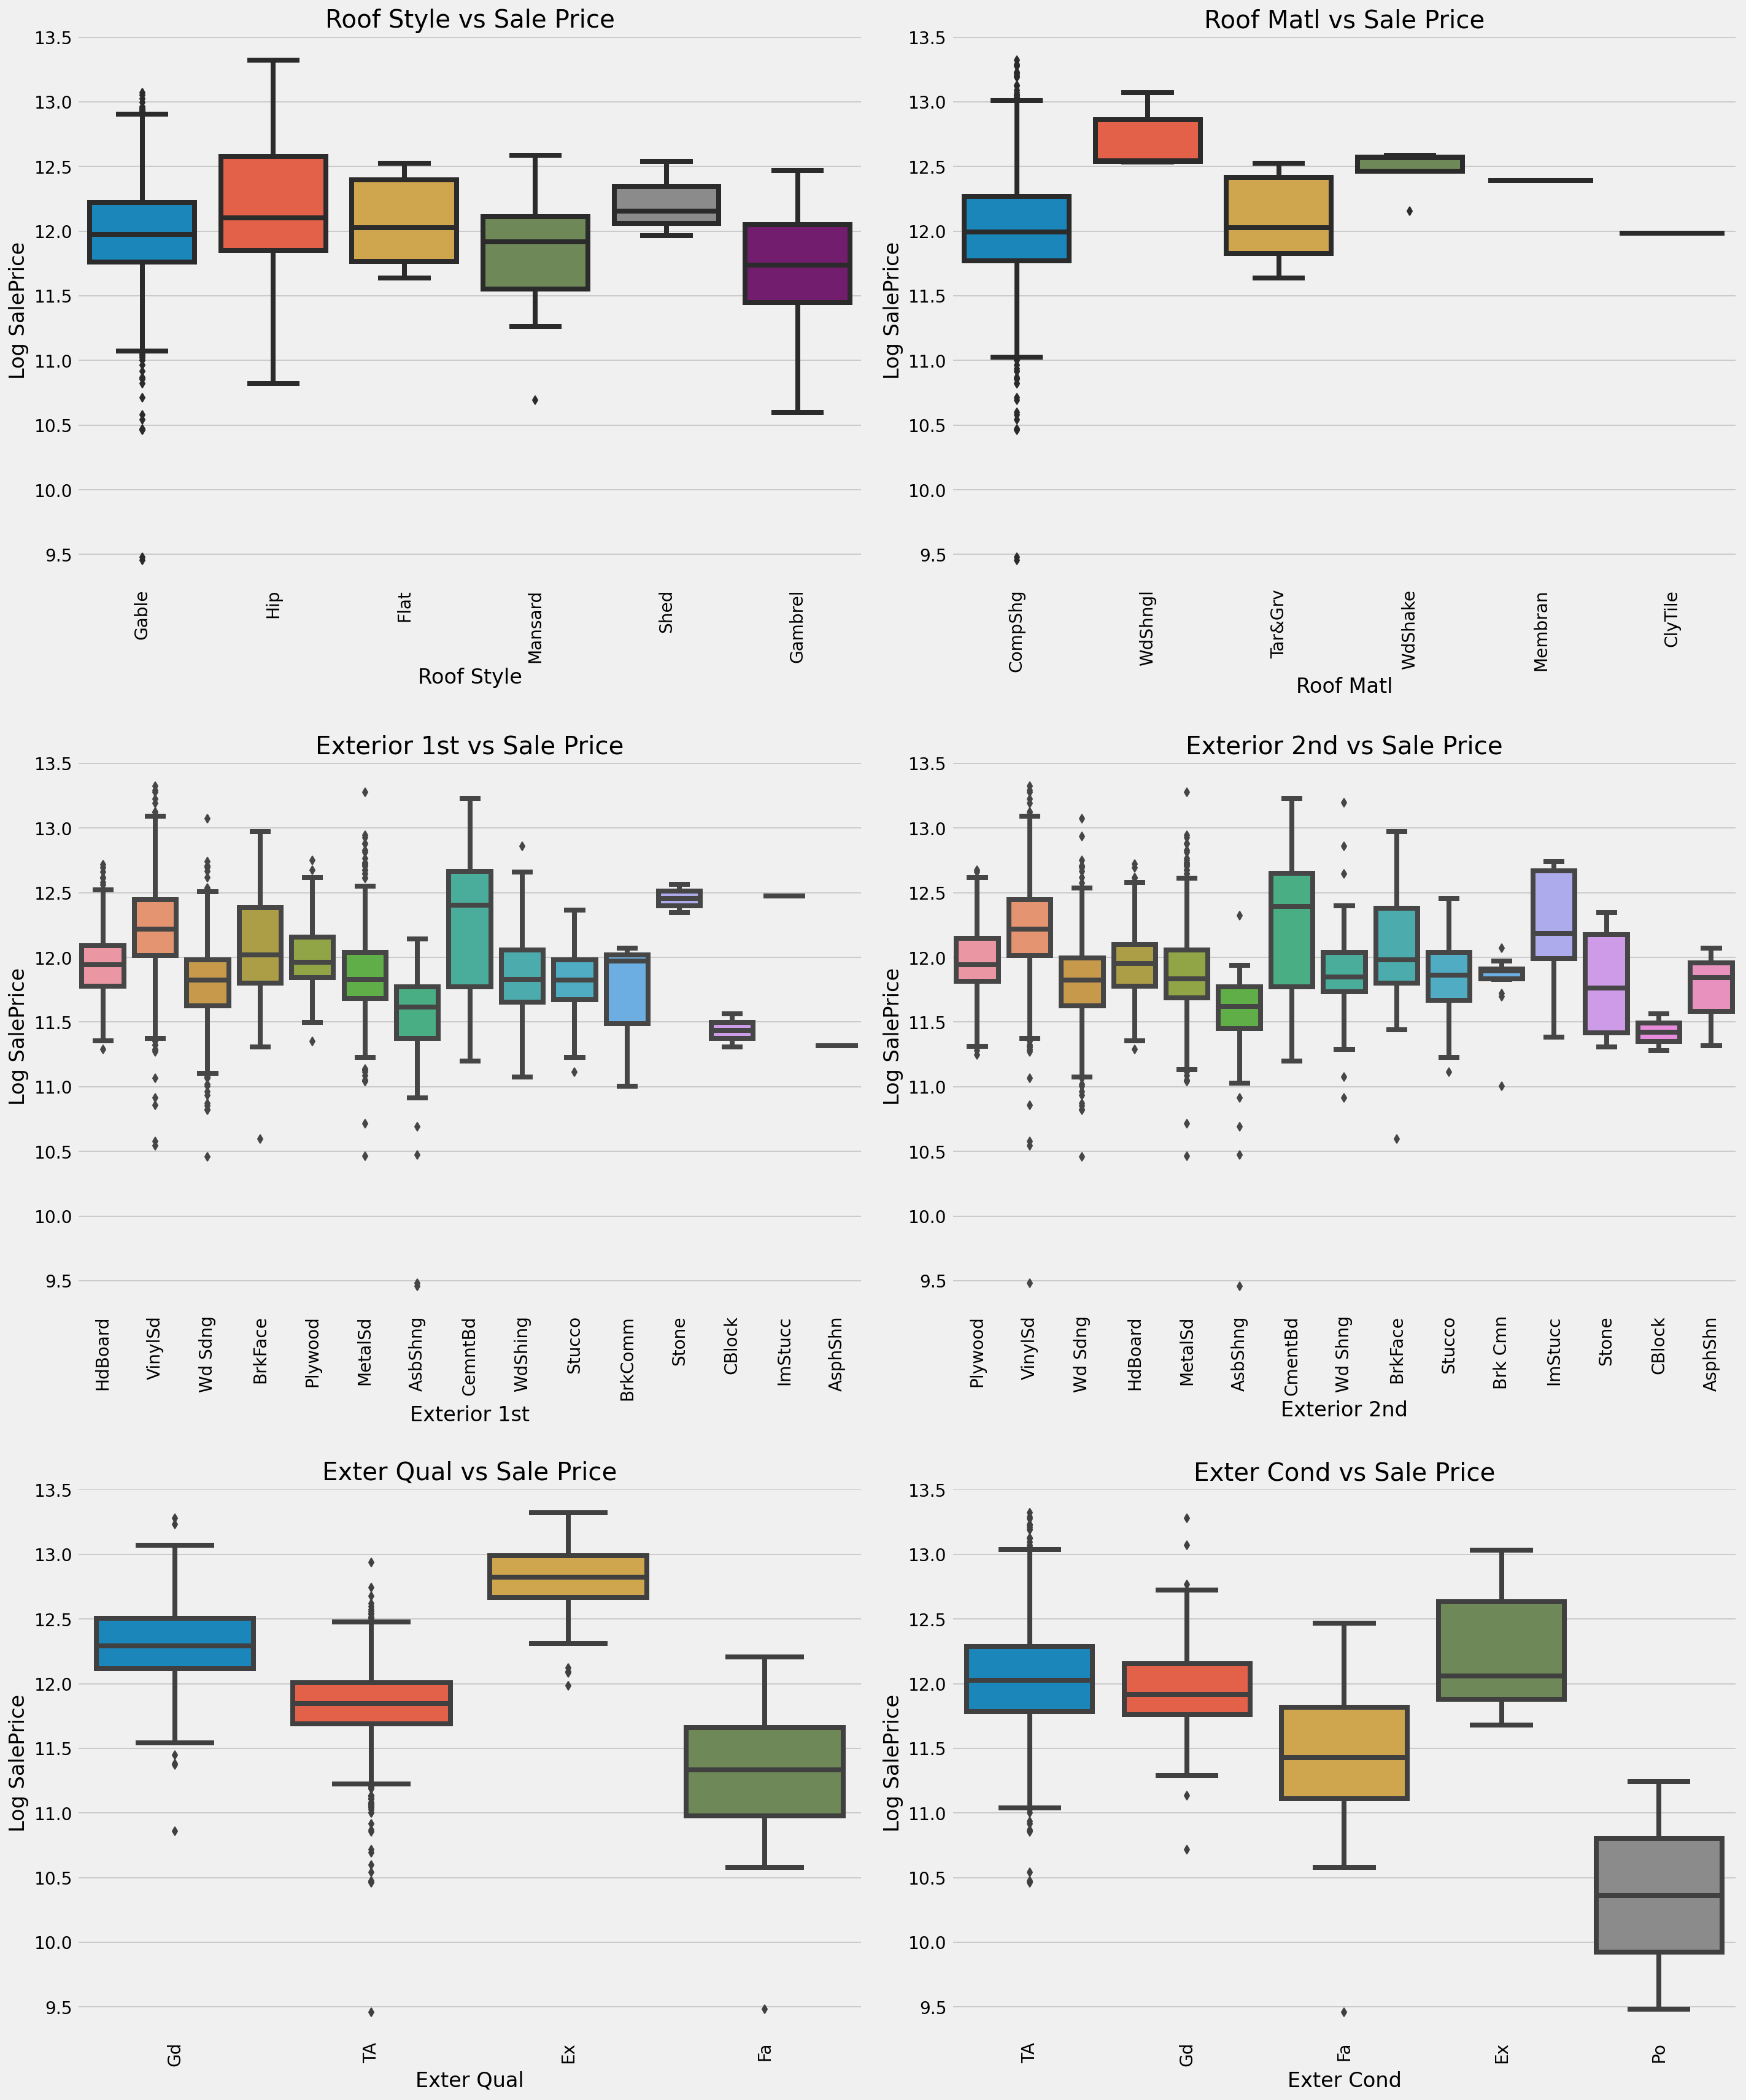

In [25]:
ext_feature_list  = [ext for ext in df_train if 'Exter'in ext or 'Roof' in ext]

EDA_subplot(3,2,ext_feature_list , df_train)

### 1.4g General Overview on House Interior Features
___

- House size observed to have a linear impact on sale price as seen from 1st flr , 2nd flr SF and Gr Liv Area
- While Kitchen quantity might not matter , kitchen quality does.
- More room , better sales price.
- Some outliers can be observed in Living Area , 4 that are very large, yet cheap.
- Brick Face and Stone are popular choice for masonary, however large portion of house does not have.
| Features        	| Type        	| Description                                                                                                                	|
|-----------------	|-------------	|----------------------------------------------------------------------------------------------------------------------------	|
| 1st Flr SF      	| Continuous  	| First Floor square feet                                                                                                    	|
| 2nd Flr SF      	| Continuous  	| Second floor square feet                                                                                                   	|
| Low Qual Fin SF 	| Continuous  	| Low quality finished square feet (all floors)                                                                              	|
| Gr Liv Area     	| Continuous  	| Above ground(above grade) living area square feet                                                                          	|
| Full Bath       	| Discrete    	| Full bathrooms above grade (above ground)                                                                                  	|
| Half Bath       	| Discrete    	| Half bathrooms above grade (above ground)                                                                                  	|
| Bedroom AbvGr   	| Discrete    	| Bedrooms above grade (does NOT include basement bedrooms)                                                                  	|
| TotRms AbvGrd   	| Discrete    	| Total rooms above grade (does not include bathrooms)                                                                       	|
| Kitchen AbvGr   	| Discrete    	| Kitchens above grade (ground)                                                                                              	|
| KitchenQual     	| Ordinal     	| Ex : Excellent<br>Gd : Good<br>TA : Typical Average<br>Fa : Fair<br>Po : Poor                                              	|
| Mas Vnr Type    	| Categorical 	| Masonry veneer type<br>BrkCmn : Brick Common<br>BrkFace : Brick Face<br>CBlock : Cinder Block<br>Stone : Stone<br>NA :None 	|
| Mas Vnr Area    	| Continuous  	| Masonry veneer area in square feet                                                                                         	|

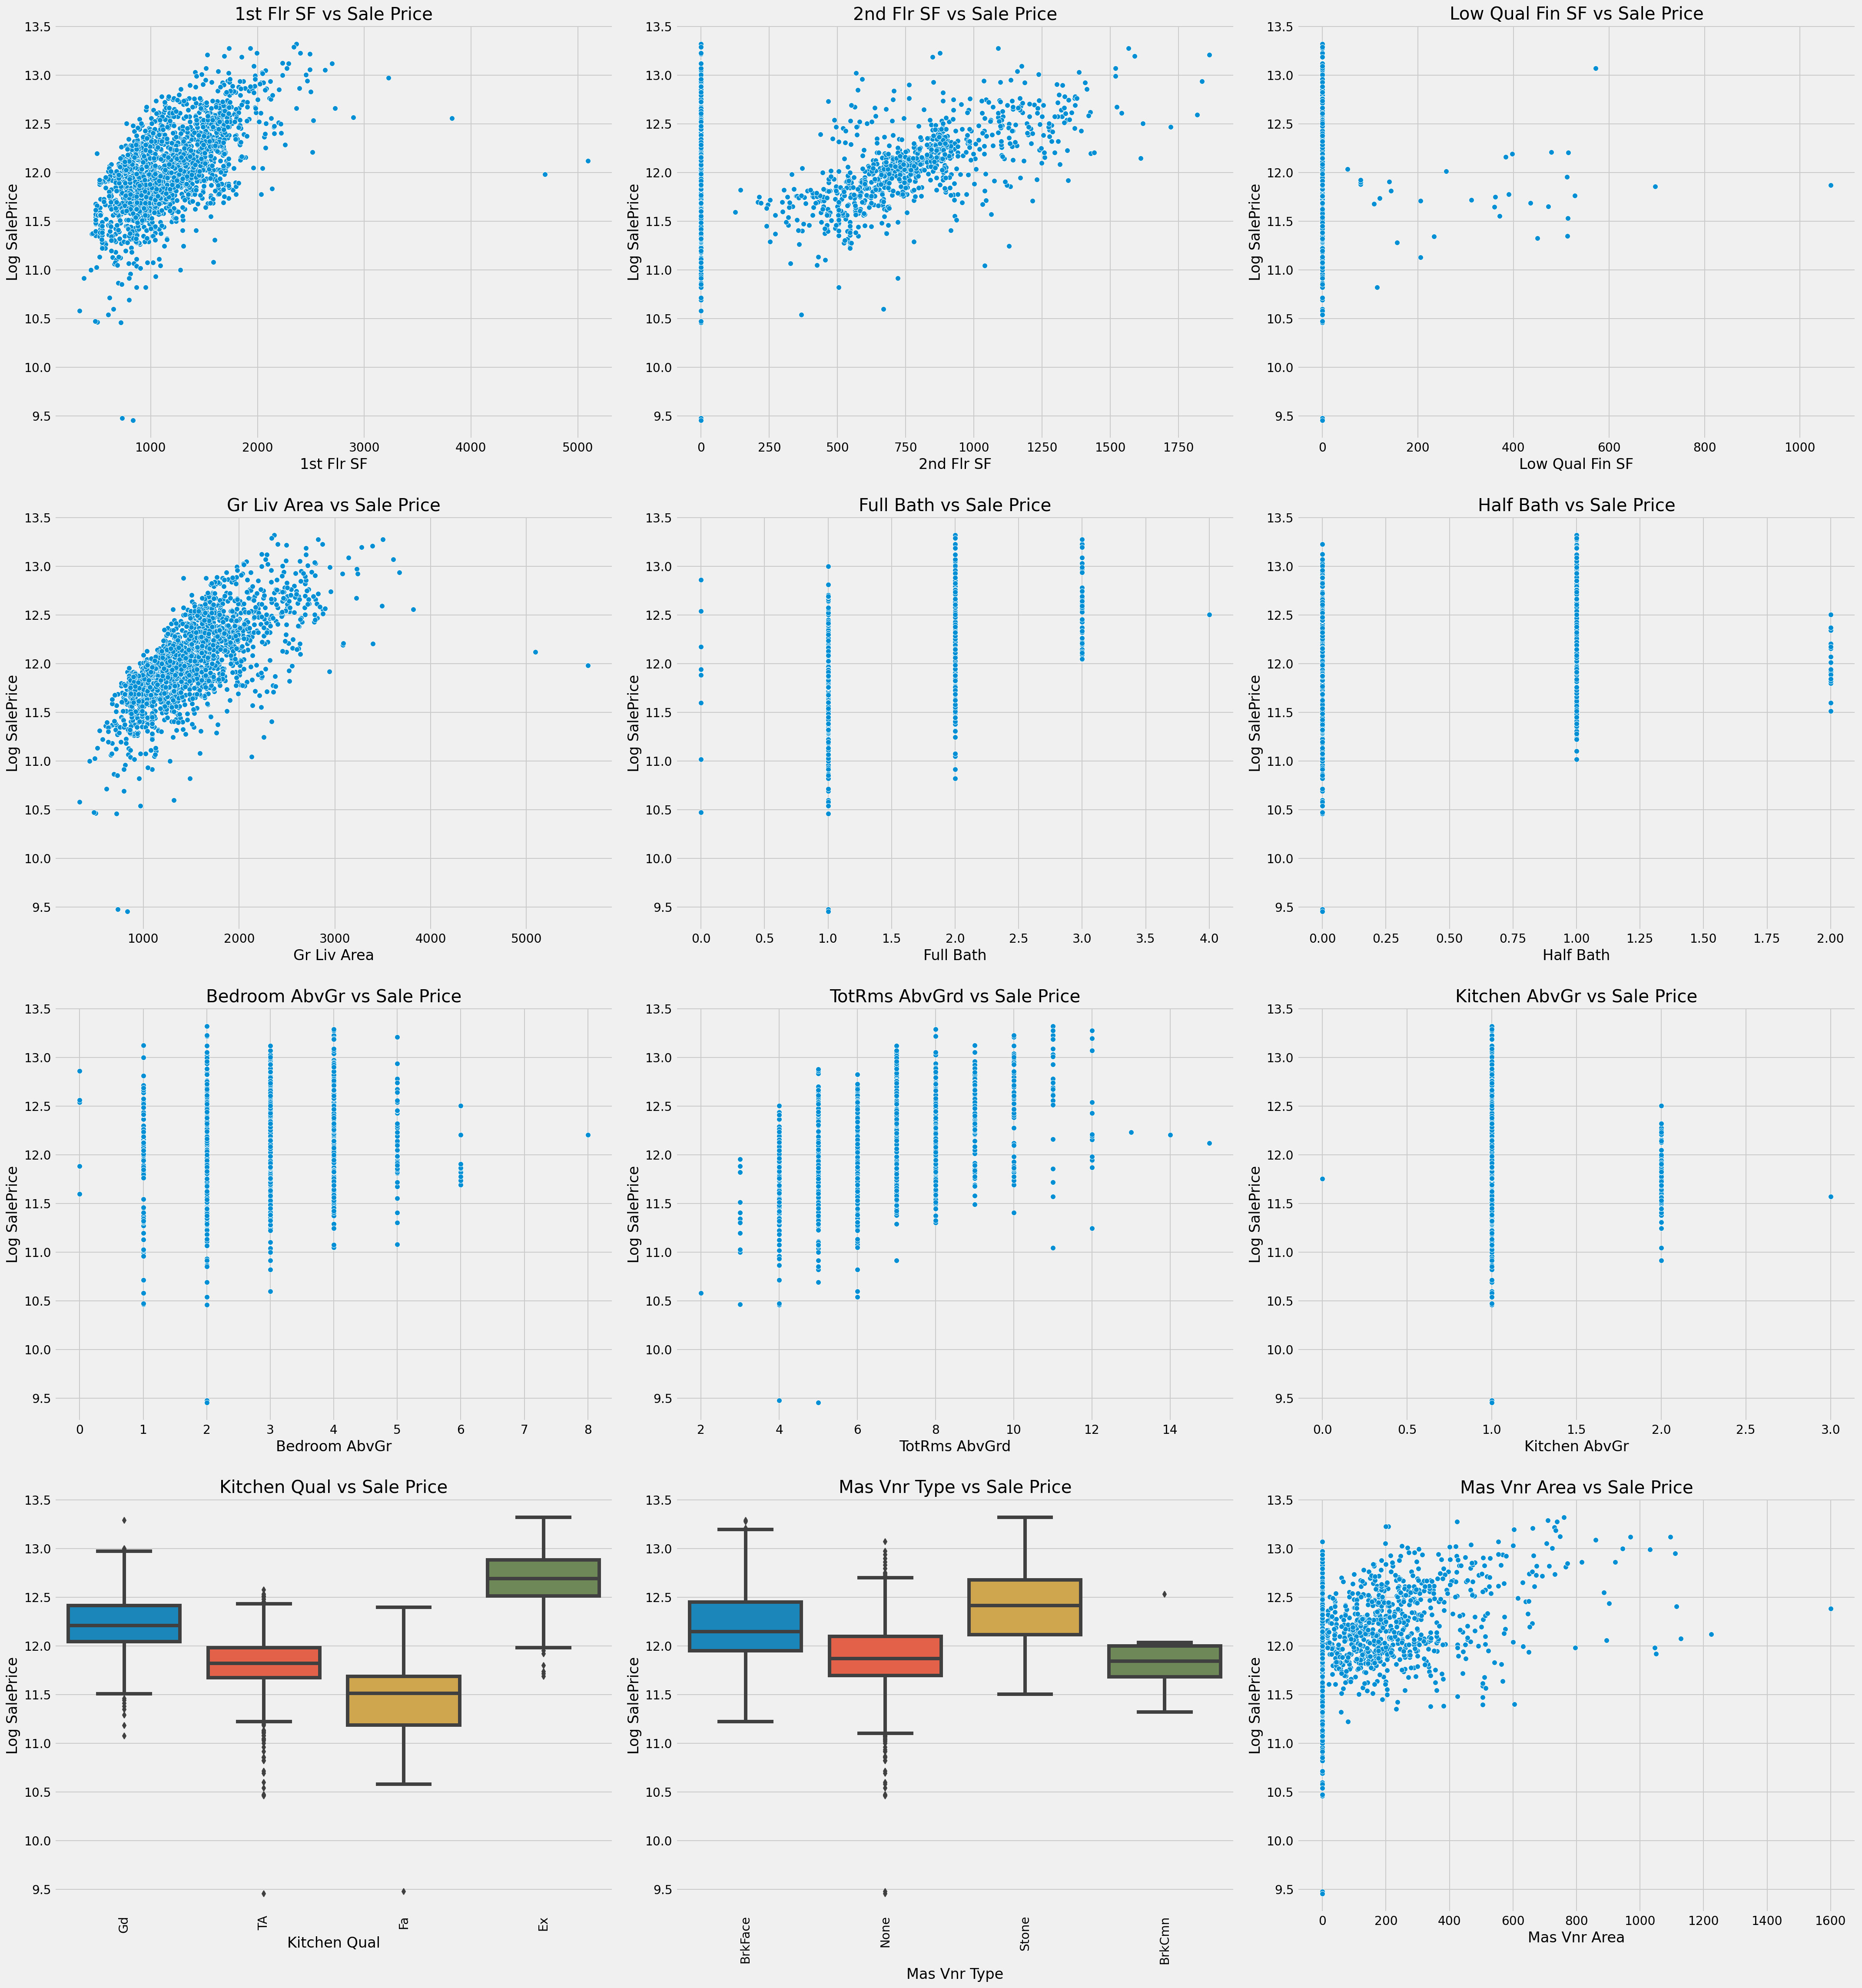

In [26]:
int_feature_list  = ['1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Full Bath', 'Half Bath', 'Bedroom AbvGr' , 'TotRms AbvGrd' ,'Kitchen AbvGr', 'Kitchen Qual' , 'Mas Vnr Type', 'Mas Vnr Area']

EDA_subplot(4,3,int_feature_list , df_train)

### 1.4h General Overview on Land Plot and Access to Land Plot
___

- Couple of Outlier could be observed in Lot Area and Lot Frontage.
- Feature of access and the land plot does not seem to have uch correlation with the SalePrice individually.

| Feature | Type | Description |
|---|---|---|
| Lot Frontage | Continuous | Linear feet of street connected to property |
| Lot Area | Continuous | Lot size in square feet |
| Street | Categorical | Type of road access to property<br>Grvl : Gravel<br>Pave : Paved |
| Alley | Categorical | Type of road access to property<br>Grvl : Gravel<br>Pave : Paved |
| Lot Shape | Ordinal | General Shape of Property<br>Reg : Regular<br>IR1 : Slightly Irregular<br>IR2 : Moderately Irregular<br>IR3 : Irregular |
| Land Slope | Ordinal | Slope of property<br>Gtl : Gentle<br>Mod : Moderate Slope<br>Sev : Severe Slope |
| Land Contour | Categorical | Flatness of the property<br>Lvl : Near Flat / Level<br>Bnk : Banked<br>HLS : Hillside<br>Low : Depression |
| Lot Config | Categorical | Lot Configuration<br>Inside : Inside Lot<br>Corner : Corner<br>CulDeSac : Cul-De-Sac<br>FR2 : Frontage on 2 sides<br>FR3 : Frontage on 3 sides |

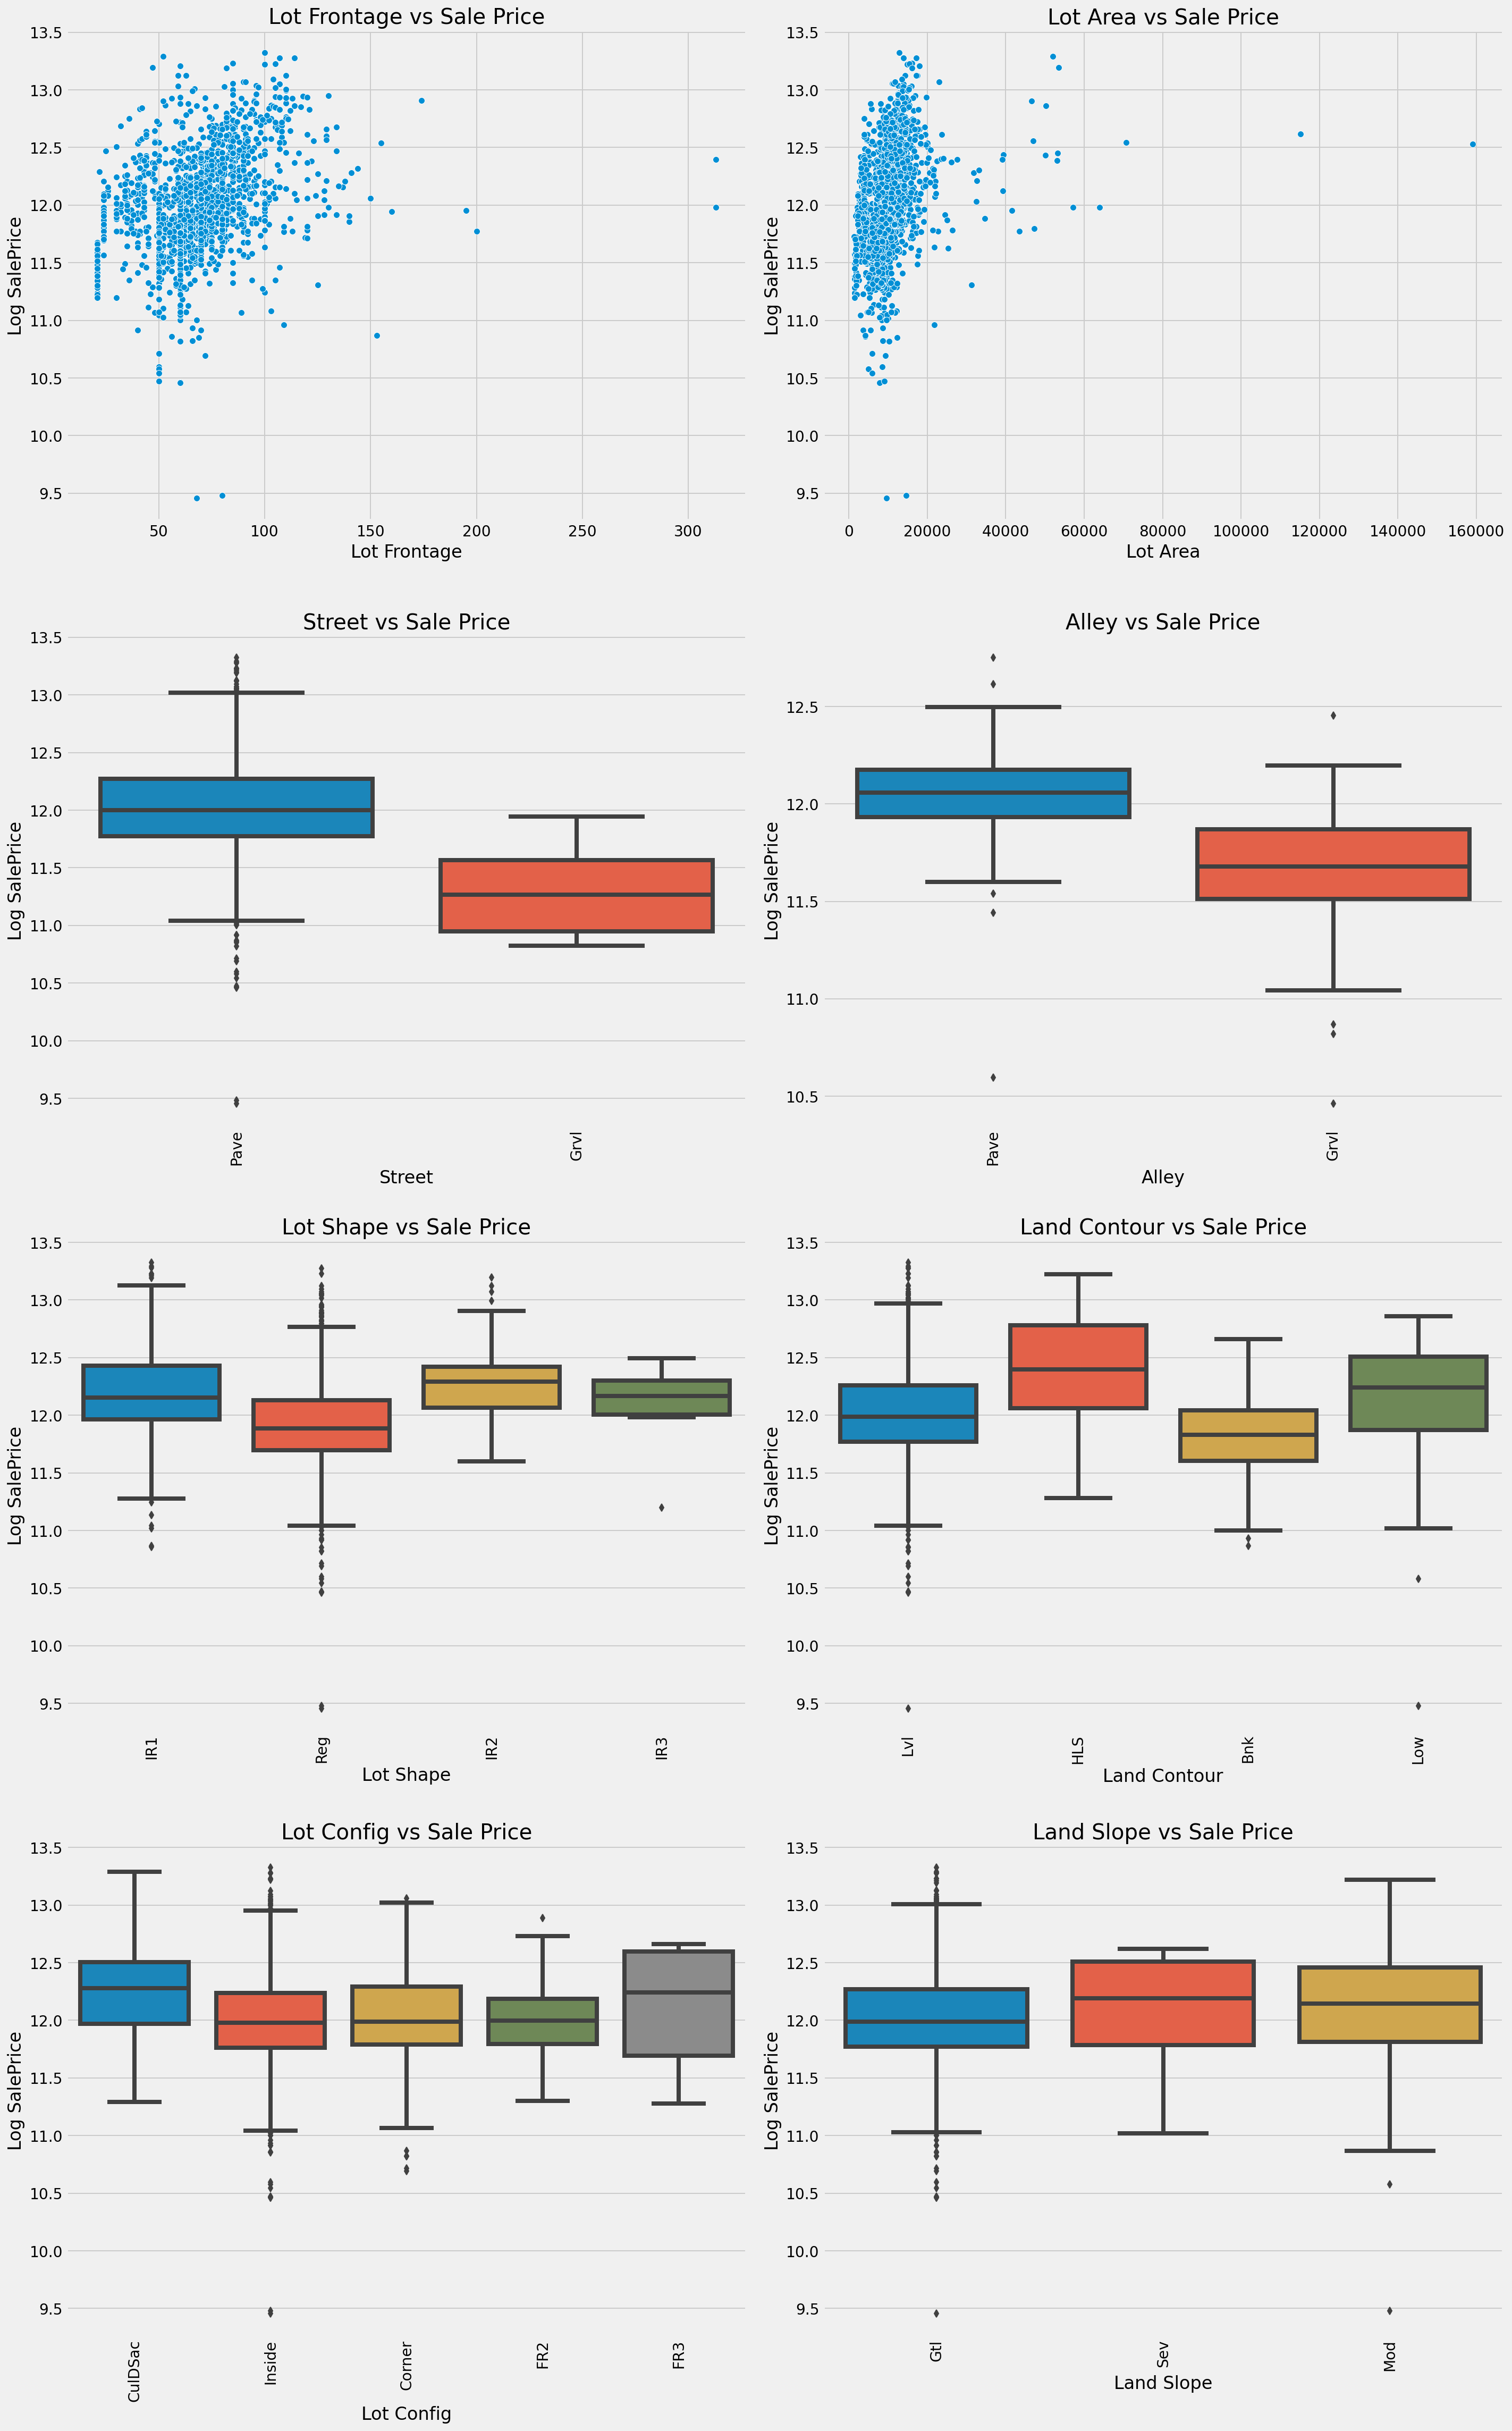

In [27]:
land_plot_list  = [lot for lot in df_train if 'Lot'in lot or 'Land' in lot or 'Street' in lot or 'Alley' in lot]
EDA_subplot(4,2 , land_plot_list , df_train)

### 1.4i General Overview on House Surrounding Features
___

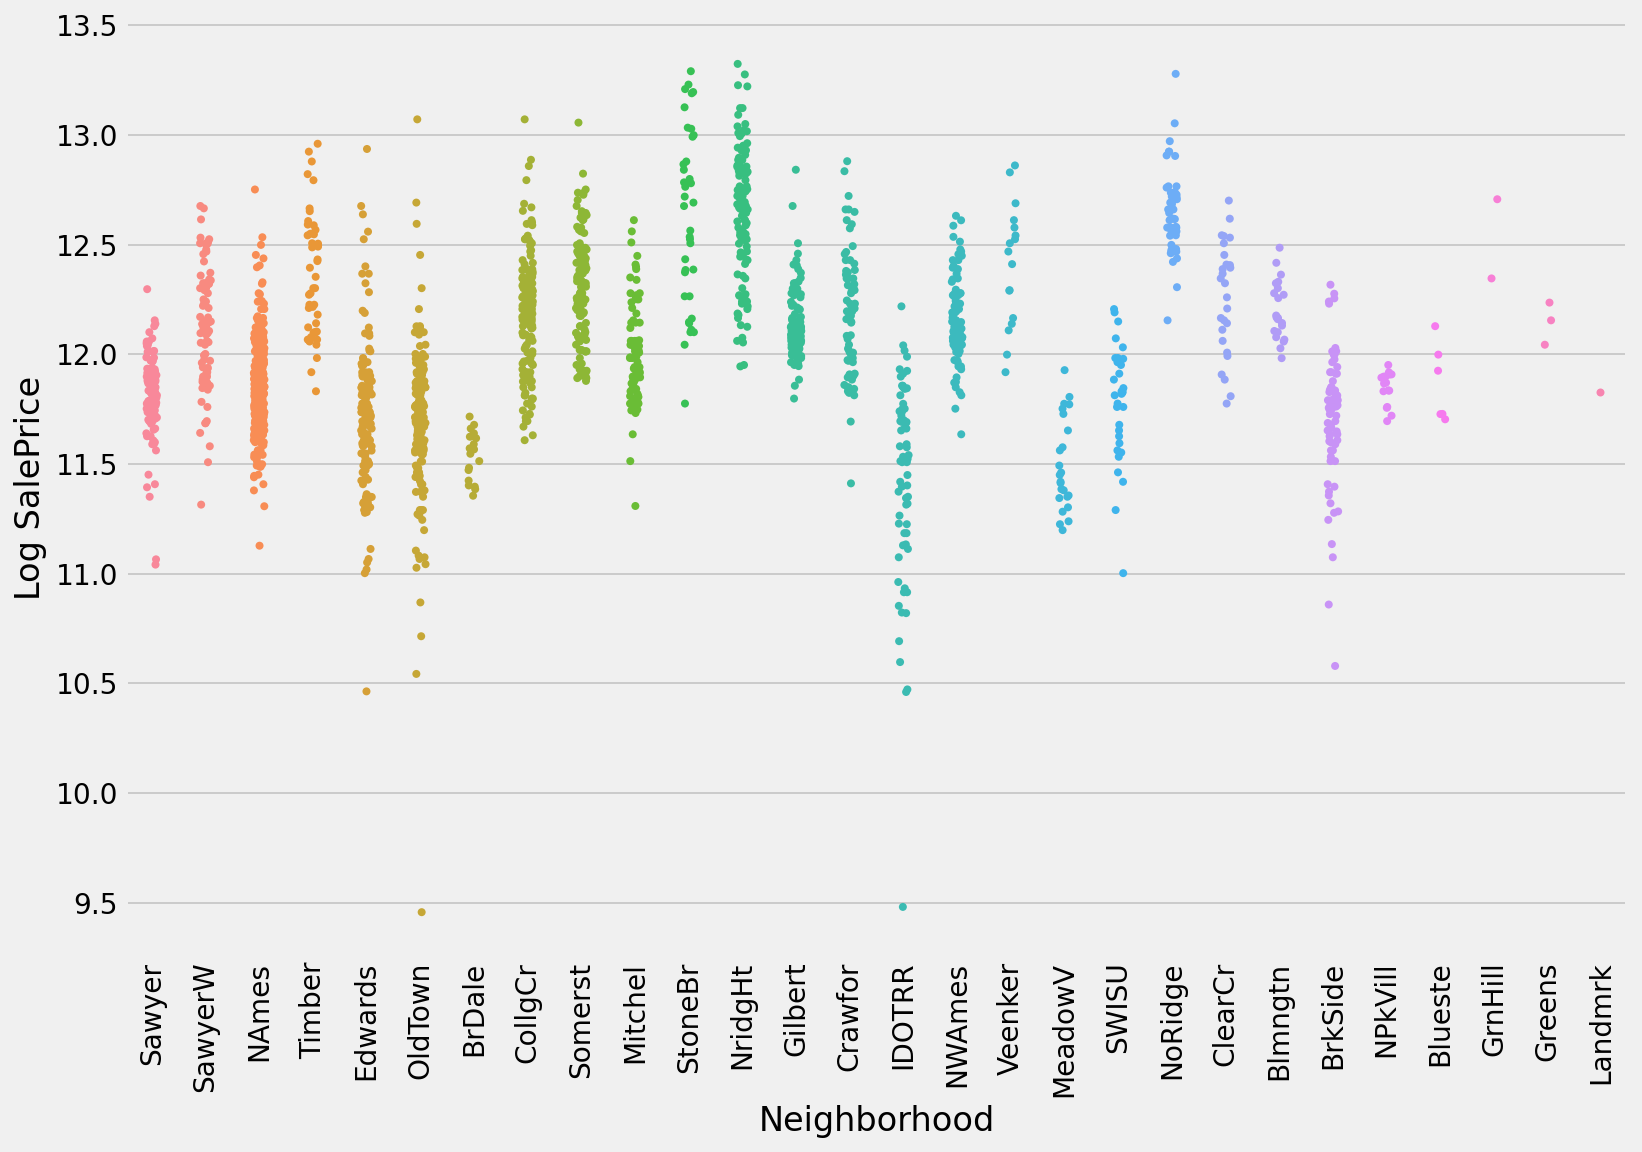

In [28]:
plt.figure(figsize = (12,8))

sns.stripplot(x = 'Neighborhood',
              y = 'Log SalePrice',
              data = df_train,
              size = 4,
              edgecolor = 'black')
plt.xticks(rotation = 90)
plt.show()

### 1.5 Standardising Column Name
___
After exploring the features , we observed that many columns contain different abbreviation that meant the same thing. It can be tough remembering too many variables when attempting to call the same category. This section is mean to standardise some of the column name and is more of a personal workstyle.

In [29]:
# Qual , Qu , QC generally refer to the same ordinal output
df_train.columns = df_train.columns.str.replace('Qual' , 'QC').str.replace('Qu' , 'QC')

# Either standadise to AbvGrd or AbvGr
df_train.columns = df_train.columns.str.replace('TotRms AbvGrd' , 'Totalrooms AbvGr')
df_train.columns = df_train.columns.str.replace('Gr Liv Area' , 'Liv Area AbvGr')

# Year or Yr
df_train.columns = df_train.columns.str.replace('Year' , 'Yr')

In [30]:
df_train.columns

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall QC', 'Overall Cond',
       'Yr Built', 'Yr Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter QC',
       'Exter Cond', 'Foundation', 'Bsmt QC', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low QC Fin SF',
       'Liv Area AbvGr', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen QC',
       'Totalrooms AbvGr', 'Functional', 'Fireplaces', 'Fireplace QC',
       'Garage Type', 'Garage Yr Blt', 'Garage Finish', 

### 1.6 Preprocessing Missing Value
___
Now that we have a better understanding of all the features , it will make our process of preprocessing missing value more reasonable

In [31]:
df_train.isnull().sum().sort_values(ascending = False).head(10)

Pool QC          2042
Misc Feature     1986
Alley            1911
Fence            1651
Fireplace QC     1000
Lot Frontage      330
Garage Cond       114
Garage Finish     114
Garage Yr Blt     114
Garage QC         114
dtype: int64

#### 1.6.1 Pool QC and Pool Area Missing Value
___
- Replace nan with 'NA'

In [32]:
df_train['Pool QC'].unique()

array([nan, 'Fa', 'Gd', 'Ex', 'TA'], dtype=object)

In [33]:
# Since original dataset is so little (8:2050) , we will simplified this column into have_pool instead, having 1 = Yes , 0 = no
minority_feature_dummify(df_train , 'Pool QC')

Before Dummify:
Gd    4
TA    2
Fa    2
Ex    1
Name: Pool QC, dtype: int64
                       
After Dummify:
0    2042
1       9
Name: Pool QC, dtype: int64


#### 1.6.2 Misc Features Missing Value
___
- Replace nan with 'NA'

In [34]:
df_train['Misc Feature'].unique()

array([nan, 'Shed', 'TenC', 'Gar2', 'Othr', 'Elev'], dtype=object)

In [35]:
# Since original dataset is so little (65:2050) , we will simplified this column into have_misc instead, having 1 = Yes , 0 = no
minority_feature_dummify(df_train , 'Misc Feature')

Before Dummify:
Shed    56
Gar2     4
Othr     3
TenC     1
Elev     1
Name: Misc Feature, dtype: int64
                       
After Dummify:
0    1986
1      65
Name: Misc Feature, dtype: int64


#### 1.6.3 Alley Missing Value
___
- Replace nan with 'NA'

In [36]:
df_train['Alley'].unique()

array([nan, 'Pave', 'Grvl'], dtype=object)

In [37]:
# Since original dataset is so little (140:2050) , we will simplified this column into have_alley instead, having 1 = Yes , 0 = no
minority_feature_dummify(df_train , 'Alley')

Before Dummify:
Grvl    85
Pave    55
Name: Alley, dtype: int64
                       
After Dummify:
0    1911
1     140
Name: Alley, dtype: int64


#### 1.6.4 Fence Missing Value
___
- Replace nan with 'NA'

In [38]:
df_train['Fence'].unique()

array([nan, 'MnPrv', 'GdPrv', 'GdWo', 'MnWw'], dtype=object)

In [39]:
# Since original dataset is so little (400:2050) , we will simplified this column into have_fence instead, having 1 = Yes , 0 = no
minority_feature_dummify(df_train , 'Fence')

Before Dummify:
MnPrv    227
GdPrv     83
GdWo      80
MnWw      10
Name: Fence, dtype: int64
                       
After Dummify:
0    1651
1     400
Name: Fence, dtype: int64


#### 1.6.5 Fireplace QC Missing Value
___
- Replace nan with 'NA'

In [40]:
df_train['Fireplace QC'].unique()

array([nan, 'TA', 'Gd', 'Po', 'Ex', 'Fa'], dtype=object)

In [41]:
# We will dummifed this column in later section base on ordinal condition
df_train['Fireplace QC'].fillna(value = 'NA',
                         inplace = True)

df_train['Fireplace QC'].value_counts()

NA    1000
Gd     523
TA     407
Fa      59
Ex      31
Po      31
Name: Fireplace QC, dtype: int64

#### 1.6.6 Lot Frontage Missing Value
___
- We will fill missing value in Lot Frontage base on the median of what type that building type is.

In [42]:
# Missing 330 Data
df_train['Lot Frontage'].describe()

count    1721.000000
mean       69.055200
std        23.260653
min        21.000000
25%        58.000000
50%        68.000000
75%        80.000000
max       313.000000
Name: Lot Frontage, dtype: float64

In [43]:
# We going to fill NaN value in Lot Frontage base on the median of the Building Type
map_cond = df_train.groupby('Bldg Type').median()['Lot Frontage'].to_dict()
map_cond

{'1Fam': 70.0, '2fmCon': 64.0, 'Duplex': 70.0, 'Twnhs': 24.0, 'TwnhsE': 41.0}

In [44]:
# Locate the row where it is np.nan in Lot Frontage
df_lot_nan = df_train['Lot Frontage'].isnull()

# Map the nan row in Lot Frontage base on mapping condition from Bldg Type
df_train.loc[df_lot_nan , 'Lot Frontage'] = df_train.loc[df_lot_nan , 'Bldg Type'].map(map_cond)

In [45]:
df_train['Lot Frontage'].describe()

count    2051.000000
mean       68.713311
std        21.668831
min        21.000000
25%        60.000000
50%        70.000000
75%        78.000000
max       313.000000
Name: Lot Frontage, dtype: float64

#### 1.6.7 Garage Feature Missing Value
___
As we recalled from earlier section 1.5 on Garage Features :
- Total 8 features for Basement : 
    - 3 numeric features : [Garage Yr Blt , Garage Cars , Garage Area]
    - 3 non-numeric ordinal features : [Garage QC , Garage Cond , Paved Drive]
    - 2 non-numeric , non-ordinal features : [Garage Type , Garage Finish]
    
- There are some houses that simply does not have a Garage , thus the consisteency of the nan value across the row
- There is a row in Garage Type that is Detchd , and nan for the rest of its feature.
- The datatype in index 1712 for Garage Cars and Area should be 0 instead of np.nan

In [46]:
# Finding Houses with no Garage

garage_list_nan = [garage for garage in df_train.columns if 'Garage' in garage]

In [47]:
# There is a row in Garage Type that have a value , and nan for the rest of its feature.
df_train[df_train['Garage Yr Blt'].isna()][garage_list_nan].sort_values(by = 'Garage Type').head()

Garage Type  Garage Yr Blt Garage Finish  Garage Cars  Garage Area  \
1712      Detchd            NaN           NaN          NaN          NaN   
28           NaN            NaN           NaN          0.0          0.0   
53           NaN            NaN           NaN          0.0          0.0   
65           NaN            NaN           NaN          0.0          0.0   
79           NaN            NaN           NaN          0.0          0.0   

     Garage QC Garage Cond  
1712       NaN         NaN  
28         NaN         NaN  
53         NaN         NaN  
65         NaN         NaN  
79         NaN         NaN

In [48]:
# Replacing non numeric Garage feature with NA

df_train.loc[1712 , 'Garage Type'] = 'NA'

for col_name , data in df_train[garage_list_nan].items():
    if not pd.api.types.is_numeric_dtype(data):
        df_train[col_name].fillna(value = 'NA', inplace = True)
    else:
        df_train[col_name].fillna(value = 0 , inplace = True)

#### 1.6.8 Basement Feature Missing Value
___
As we recalled frome arlier section 1.5 on Basement Features :
- Total 11 features for Basement : 
    - 6 numeric features : [BsmtFin SF 1, BsmtFin SF 2 , Bsmt Unf SF , Total Bsmt SF , Bsmt Full Bath , Bsmt Half Bath]
    - 4 non-numeric ordinal features : ['Bsmt Qual', 'Bsmt Cond' , 'BsmtFin Type 1' , 'BsmtFin Type 2']
    - 1 non-numeric , non-ordinal features : ['Bsmt Exposure']
    
- There are some houses that simply does not have Basement , thus the consisteency of the nan value across the row.
- There are 3 rows in Basement Type that have a value , and nan for the rest of its feature.
- There are 2 inconsistency for bsmt features with Bsmt SF

In [49]:
# Finding houses with no Basement
basement_list = [bsmt for bsmt in df_train.columns if 'Bsmt' in bsmt]

df_train[df_train['Bsmt Exposure'].isnull()][basement_list].sort_values(by = 'Bsmt QC').head()

Bsmt QC Bsmt Cond Bsmt Exposure BsmtFin Type 1  BsmtFin SF 1  \
1456      Gd        TA           NaN            Unf           0.0   
1547      Gd        TA           NaN            Unf           0.0   
1997      Gd        TA           NaN            Unf           0.0   
12       NaN       NaN           NaN            NaN           0.0   
93       NaN       NaN           NaN            NaN           0.0   

     BsmtFin Type 2  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  Bsmt Full Bath  \
1456            Unf           0.0        725.0          725.0             0.0   
1547            Unf           0.0       1595.0         1595.0             0.0   
1997            Unf           0.0        936.0          936.0             0.0   
12              NaN           0.0          0.0            0.0             0.0   
93              NaN           0.0          0.0            0.0             0.0   

      Bsmt Half Bath  
1456             0.0  
1547             0.0  
1997             0.0  
12               0.0  
93               0.0

In [50]:
# Base on most Basement Type 1 with Unf & Bsmt Cond with TA , the mode value for BSMT Exposure is No
df_train.loc[df_train['BsmtFin Type 1'] == 'Unf' , :][['BsmtFin Type 1' , 'Bsmt Exposure']].value_counts()

BsmtFin Type 1  Bsmt Exposure
Unf             No               478
                Av                62
                Mn                41
                Gd                19
dtype: int64

In [51]:
# Inconsistency in rows with 0 SF.

df_train[df_train['Bsmt Full Bath'].isnull()][basement_list].sort_values(by = 'Bsmt Full Bath').head()

Bsmt QC Bsmt Cond Bsmt Exposure BsmtFin Type 1  BsmtFin SF 1  \
616      NaN       NaN           NaN            NaN           0.0   
1327     NaN       NaN           NaN            NaN           NaN   

     BsmtFin Type 2  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  Bsmt Full Bath  \
616             NaN           0.0          0.0            0.0             NaN   
1327            NaN           NaN          NaN            NaN             NaN   

      Bsmt Half Bath  
616              NaN  
1327             NaN

In [52]:
# Replacing 3 outlier Bsmt Exposure feature with No

df_train.loc[1456 , 'Bsmt Exposure'] = 'No'
df_train.loc[1547 , 'Bsmt Exposure'] = 'No'
df_train.loc[1997 , 'Bsmt Exposure'] = 'No'

In [53]:
# Replacing the numeric nan value in basement feature with 0 and non-numeric nan value with 'NA'
for col_name , data in df_train[basement_list].items():
    if pd.api.types.is_numeric_dtype(data):
        df_train[col_name].fillna(value = 0 , inplace = True)
    else:
        df_train[col_name].fillna(value = 'NA' , inplace = True)        

#### 1.6.9 Masonary Feature Missing Value
___

-  Recall from above visualisation from section 1.5 , there are 2 features on Masonary:
    - Mas Vnr Type : 4 Non-ordinal features : BrkFace , None , Stone , BrkCmn
    - Mas Vnr Area : Numerical 
    
-  No. of Nan value for Vnr Type and Vnr Area is the same. Thus we can safely conclude that Masonary feature is not present in these 22 houses.
- For Numeric features , we will fillna with 0.
- For Non-Numeric Feature , we will fillna with None

In [54]:
df_train['Mas Vnr Type'].unique()

array(['BrkFace', 'None', nan, 'Stone', 'BrkCmn'], dtype=object)

In [55]:
# No. of Nan value for Vnr Type and Vnr Area is the same. 
# Thus we can safely conclude that Masonary feature is not present in these 22 houses.

mas_list = [mas for mas in df_train if 'Mas' in mas]
df_train[df_train['Mas Vnr Type'].isnull()][mas_list].head()

Mas Vnr Type  Mas Vnr Area
22           NaN           NaN
41           NaN           NaN
86           NaN           NaN
212          NaN           NaN
276          NaN           NaN

In [56]:
# For Numeric features , we will fillna with 0.
# For Non-Numeric Feature , we will fillna with None.

df_train['Mas Vnr Type'].fillna(value = 'None' , inplace = True)
df_train['Mas Vnr Area'].fillna(value = 0 , inplace = True)

#### 1.6.10 Summary of DF after preprocessing Missing Value
___

In [57]:
print(f'Total null elements in df: {df_train.isnull().sum().sum()}')

Total null elements in df: 0


#### 1.7 Preprocessing Outliers
___

From earlier visualisation , some of the outlier can be shown very clearly from the plots. In this section , we will clean those outliers up before dummifying the columns in Section 2.0.

- PSF : remove 10 extreme low PSF
- Garage Yr Blt : Go back 200 year to the future and bring it back to the correct year.

#### 1.7.1 Low PSF Outliers observed for Large Basement , Large SF Area
___

In [58]:
# Creating a new feature Call PSF (Price per Square FT)
df_train['PSF'] = df_train['SalePrice'] / df_train['Liv Area AbvGr'] 

In [59]:
# 10 extreme outliers with very low PSF (less than $40 PSF).. where got so cheap one....
df_train[['Liv Area AbvGr' , 'SalePrice' , 'PSF']].sort_values(by = 'PSF' , ascending = True).head(10)

Liv Area AbvGr  SalePrice        PSF
1628             832      12789  15.371394
183              733      13100  17.871760
960             5642     160000  28.358738
162             2128      62500  29.370301
408             1317      40000  30.372058
1301            1484      50000  33.692722
562             2256      76500  33.909574
1885            5095     183850  36.084396
893             2337      90000  38.510911
1564             968      37900  39.152893

In [60]:
# Super Large Basement Base... As large As Liv Area above Ground
df_train[['Total Bsmt SF' ,'Liv Area AbvGr']].sort_values(by = 'Total Bsmt SF' , ascending = False).head()

Total Bsmt SF  Liv Area AbvGr
960          6110.0            5642
1885         5095.0            5095
1147         3206.0            1629
328          3200.0            3228
1164         3094.0            2402

In [61]:
print(f'Df shape before remove rows : {df_train.shape}')

df_train = df_train[df_train['PSF'] > 40]

print(f'Df shape after remove rows : {df_train.shape}')

Df shape before remove rows : (2051, 86)
Df shape after remove rows : (2041, 86)


#### 1.7.2 Garage Back to the Future (Yr 2207 to Yr 2007)
___

In [62]:
df_train['Garage Yr Blt'].sort_values(ascending = False).head()

1699    2207.0
144     2010.0
1241    2010.0
1700    2009.0
1796    2009.0
Name: Garage Yr Blt, dtype: float64

In [63]:
df_train.loc[1699 , 'Garage Yr Blt'] = 2007

#### 1.7.3 Super Large Lot Area
___

In [64]:
df_train[['Lot Area' , 'Liv Area AbvGr']].sort_values(by = 'Lot Area' , ascending = False).head()

Lot Area  Liv Area AbvGr
471     159000            2144
694     115149            1824
1854     70761            1533
745      57200            1687
823      53504            3279

In [65]:
print(f'Df shape before remove rows : {df_train.shape}')

df_train = df_train[df_train['Lot Area'] < 100000]

print(f'Df shape after remove rows : {df_train.shape}')

Df shape before remove rows : (2041, 86)
Df shape after remove rows : (2039, 86)


# 2.0 Feature Engineeering
___

- 2.1 Dummfying Ordinal feature with pre-defined dictionary
- 2.2 Dummfting Non-Ordinal Categorical feature with pd.getdummies
- 2.3 Creating New features
- 2.4 Dropping Features

### 2.1 Dummfying Ordinal Categorical Feature
___

| Ordinal Feature | Location of House | Description |
|---|---|---|
| Bsmt QC<br>Garage QC<br>Fireplace QC<br>Exter QC | Common QC Feature | 'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1,'NA': 0 |
| Bsmt Cond<br>Garage Cond<br>Fireplace Cond<br>Exter Cond | Common Cond Feature | 'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1,'NA': 0 |
| Bsmt Exposure | Basement | 'Av': 3, 'Mn': 2, 'No': 1 |
| BsmtFin Type 1 | Basement | 'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1 |
| BsmtFin Type 2 | Basement | 'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1 |
| Garage Finish | Garage | 'Fin': 3, 'RFn': 2, 'Unf':1 |
| Paved Drive | Garage | 'Y' : 2, 'P' : 1, 'N' : 0, |
| Lot Shape | Land Plot Feature | 'Reg':4, 'IR1':3, 'IR2':2, 'IR3':1, |
| Land Slope | Land Plot Feature | 'Gtl':3, 'Mod':2,'Sev':1 |
| Electrical | Heating & Utilities | 'SBrkr':4, 'FuseA':3, 'FuseF':2, 'FuseP':1, 'Mix':1, |
| Utilities | Heating & Utilities | 'AllPub':4, 'NoSewr':3, 'NoSeWa':2, 'ELO':1 |

In [66]:
# Creating ordinal dict for non-numeric features    
    
ordinal_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1,'NA': 0,
                # Basement Features
                'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, 
                'Av': 3, 'Mn': 2, 'No': 1, 
                #Garage Features
                'Fin': 3, 'RFn': 2, 'Unf':1,
                 'Y' : 2, 'P' : 1, 'N' : 0,
                # Land Plot Feature
                'Reg':4, 'IR1':3, 'IR2':2, 'IR3':1,
                'Gtl':3, 'Mod':2,'Sev':1,
                # Heating and Utilities Related
                'SBrkr':4, 'FuseA':3, 'FuseF':2, 'FuseP':1, 'Mix':1,
                'AllPub':4, 'NoSewr':3, 'NoSeWa':2, 'ELO':1,
                'Typ':1, 'Min1':0, 'Min2':0, 'Mod':0, 'Maj1':0,'Maj2':0,'Sev':0,'Sal':0
               }                  

In [67]:
# Replacing ordinal categorical feature with pre-defined dictionary
for col_name in df_train.columns:
    df_train.replace({col_name:ordinal_dict} , inplace = True)

### 2.2 Dummfying Non - Ordinal Categorical Feature
___

In [68]:
for col_name , data in df_train.items():
    if not pd.api.types.is_numeric_dtype(data):
        df_train[col_name] = pd.get_dummies(data)

In [69]:
pd.set_option('display.max_columns', None)
df_train.head(10)

Id        PID  MS SubClass  MS Zoning  Lot Frontage  Lot Area  Street  \
0   109  533352170           60          0          70.0     13517       0   
1   544  531379050           60          0          43.0     11492       0   
2   153  535304180           20          0          68.0      7922       0   
3   318  916386060           60          0          73.0      9802       0   
4   255  906425045           50          0          82.0     14235       0   
5   138  535126040           20          0         137.0     16492       0   
6  2827  908186070          180          0          35.0      3675       0   
7   145  535154050           20          0          70.0     12160       0   
8  1942  535353130           20          0          70.0     15783       0   
9  1956  535426130           60          0          70.0     11606       0   

   Alley  Lot Shape  Land Contour  Utilities  Lot Config  Land Slope  \
0      0          3             0          4           0           3   
1      0          3             0          4           0           3   
2      0          4             0          4           0           3   
3      0          4             0          4           0           3   
4      0          3             0          4           0           3   
5      0          3             0          4           1           3   
6      0          4             0          4           0           3   
7      0          3             0          4           0           3   
8      0          4             0          4           0           3   
9      0          3             0          4           0           0   

   Neighborhood  Condition 1  Condition 2  Bldg Type  House Style  Overall QC  \
0             0            0            0          1            0           6   
1             0            0            0          1            0           7   
2             0            0            0          1            0           5   
3             0            0            0          1            0           5   
4             0            0            0          1            1           6   
5             0            0            0          1            0           6   
6             0            0            0          0            0           6   
7             0            0            0          1            0           5   
8             0            1            0          1            0           5   
9             0            0            0          1            0           5   

   Overall Cond  Yr Built  Yr Remod/Add  Roof Style  Roof Matl  Exterior 1st  \
0             8      1976          2005           0          1             0   
1             5      1996          1997           0          1             0   
2             7      1953          2007           0          1             0   
3             5      2006          2007           0          1             0   
4             8      1900          1993           0          1             0   
5             6      1966          2002           0          1             0   
6             5      2005          2006           0          1             0   
7             5      1959          1959           0          1             0   
8             5      1952          1952           0          1             0   
9             5      1969          1969           0          1             0   

   Exterior 2nd  Mas Vnr Type  Mas Vnr Area  Exter QC  Exter Cond  Foundation  \
0             0             0         289.0         4           3           0   
1             0             0         132.0         4           3           0   
2             0             0           0.0         3           4           0   
3             0             0           0.0         3           3           0   
4             0             0           0.0         3           3           0   
5             0             0           0.0         4           3           0   
6            

### 2.3 Newly Created Features
___
Some of the features had been created previously and visualised, while some more new features are going to be created here to simplified the model.
- PSF : Total Area Above Ground / Sales Price
- Total Porch SF : All Features of Porch added together
- Building Age : Year Modified / Year Built - Year Sold
- Log SalePrice - Log of the Sales Price
- Total Bathroom

# 3.0 Modelling
___

- 3.1 Prepare Dataset
- 3.2 Cross Eveluation baseline performance for various estimator
- 3.3 feature Importances
- 3.4 Hyper-parameter tuning

In [108]:
np.random.seed(42)

X = df_train.drop(['Log SalePrice' , 'SalePrice' , 'PID' , 'Id'] , axis = 1)
y = df_train['SalePrice']


X_train , X_val , y_train , y_val = train_test_split(X , y , test_size = 0.2)

ss = StandardScaler()

ss.fit_transform(X_train)
ss.fit(X_val)

print(f'X_train Shape : {X_train.shape}')
print(f'X_val Shape : {X_val.shape}')
print(f'y_train Shape : {y_train.shape}')
print(f'y_val Shape : {y_val.shape}')

X_train Shape : (1631, 82)
X_val Shape : (408, 82)
y_train Shape : (1631,)
y_val Shape : (408,)


In [109]:
from sklearn.linear_model import LassoCV , RidgeCV

In [110]:
lasso_cv = LassoCV(n_alphas = 20,
                   cv = 10,
                   verbose = False)

lasso_cv.fit(X_train , y_train)

LassoCV(cv=10, n_alphas=20)

In [111]:
lasso_cv.alpha_

147797.5100039987

In [112]:
lasso = Lasso(alpha = lasso_cv.alpha_)
lasso.fit(X_train , y_train)

Lasso(alpha=147797.5100039987)

In [113]:
df_lasso = pd.DataFrame(index= X.columns,
                        data = {'coef_' :lasso.coef_})
df_lasso.sort_values(by = 'coef_' , ascending = False).head(10)

coef_
PSF             1319.316099
Liv Area AbvGr   108.803591
Mas Vnr Area      24.953918
Garage Area       13.505191
Total Bsmt SF     11.274119
BsmtFin SF 1       2.810660
1st Flr SF         1.911975
Total Porch SF     0.800170
2nd Flr SF         0.632310
Lot Area           0.082713

In [114]:
eval_pred(lasso)

Score
Training MAE            10542.045530
Validation MAE           9881.541258
Training RMSE           16656.764466
Validation RMSE         14769.228891
Training R^2 Score          0.955827
Validation R^2 Score        0.963808
Training Model Score        0.955827
Validation Model Score      0.963808

In [115]:
ridge_cv = RidgeCV(alphas = np.logspace(0 , 10 , 200),
                   cv = 10)

ridge_cv.fit(X_train , y_train)

RidgeCV(alphas=array([1.00000000e+00, 1.12266777e+00, 1.26038293e+00, 1.41499130e+00,
       1.58856513e+00, 1.78343088e+00, 2.00220037e+00, 2.24780583e+00,
       2.52353917e+00, 2.83309610e+00, 3.18062569e+00, 3.57078596e+00,
       4.00880633e+00, 4.50055768e+00, 5.05263107e+00, 5.67242607e+00,
       6.36824994e+00, 7.14942899e+00, 8.02643352e+00, 9.01101825e+00,
       1.01163798e+01, 1.13573336e+0...
       6.98587975e+08, 7.84282206e+08, 8.80488358e+08, 9.88495905e+08,
       1.10975250e+09, 1.24588336e+09, 1.39871310e+09, 1.57029012e+09,
       1.76291412e+09, 1.97916687e+09, 2.22194686e+09, 2.49450814e+09,
       2.80050389e+09, 3.14403547e+09, 3.52970730e+09, 3.96268864e+09,
       4.44878283e+09, 4.99450512e+09, 5.60716994e+09, 6.29498899e+09,
       7.06718127e+09, 7.93409667e+09, 8.90735464e+09, 1.00000000e+10]),
        cv=10)

In [116]:
ridge_cv.alpha_

25.52908068239518

In [117]:
ridge = Ridge(alpha = ridge_cv.alpha_)
ridge.fit(X_train , y_train)

Ridge(alpha=25.52908068239518)

In [118]:
df_ridge = pd.DataFrame(index= X.columns,
                        data = {'coef_' :ridge.coef_})
df_ridge.sort_values(by = 'coef_' , ascending = False).head(15)

coef_
Exter QC          5048.555694
Bldg Type         4429.233152
Half Bath         4303.445690
Heating           4034.761508
House Style       3767.111476
Kitchen QC        2762.797995
Exterior 1st      2500.338286
Misc Feature      2051.133519
Functional        1798.369349
Garage QC         1770.320535
Totalrooms AbvGr  1642.408520
Street            1631.743745
Foundation        1617.841864
Sale Type         1597.378686
PSF               1531.077712

In [119]:
eval_pred(ridge)

Score
Training MAE             9072.579272
Validation MAE           9005.652791
Training RMSE           13589.597429
Validation RMSE         13295.901972
Training R^2 Score          0.970597
Validation R^2 Score        0.970669
Training Model Score        0.970597
Validation Model Score      0.970669

In [120]:
estimators = {'Linear Regression:' : LinearRegression(),
              'Lasso :' : Lasso(alpha = lasso_cv.alpha_, max_iter = 5000),
              'Ridge :' : Ridge(alpha = ridge_cv.alpha_, max_iter = 5000)}


np.random.seed(42)

score_list = []
for name , estimator in estimators.items():
    estimator.fit(X_train , y_train)
    score_list.append([name , cross_val_score(estimator , X , y , cv = 10).mean()])
score_list

[['Linear Regression:', 0.9660779275414777],
 ['Lasso :', 0.9553695188242045],
 ['Ridge :', 0.9674184325620876]]

In [121]:
df_ridge.head(10).to_dict()

{'coef_': {'MS SubClass': 20.496334986577295,
  'MS Zoning': 0.0,
  'Lot Frontage': -24.750343930742673,
  'Lot Area': 0.0346886968726645,
  'Street': 1631.7437449942813,
  'Alley': -2006.5171400191978,
  'Lot Shape': 1280.1514275786462,
  'Land Contour': -1425.0629027294165,
  'Utilities': 204.0854789137191,
  'Lot Config': -902.5861289090977}}

In [122]:
X_top10 = df_lasso.sort_values(by = 'coef_', ascending = False).index[:10].to_list()

In [123]:
X_top10

['PSF',
 'Liv Area AbvGr',
 'Mas Vnr Area',
 'Garage Area',
 'Total Bsmt SF',
 'BsmtFin SF 1',
 '1st Flr SF',
 'Total Porch SF',
 '2nd Flr SF',
 'Lot Area']

In [132]:
np.random.seed(42)

X = df_train[X_top10]
y = df_train['SalePrice']

ss = StandardScaler()

ss.fit_transform(X)

X_train , X_val , y_train , y_val = train_test_split(X , y , test_size = 0.2)



print(f'X_train Shape : {X_train.shape}')
print(f'X_val Shape : {X_val.shape}')
print(f'y_train Shape : {y_train.shape}')
print(f'y_val Shape : {y_val.shape}')

X_train Shape : (1631, 10)
X_val Shape : (408, 10)
y_train Shape : (1631,)
y_val Shape : (408,)


In [133]:
lasso_cv = LassoCV(n_alphas = 20,
                   cv = 10,
                   verbose = False)

lasso_cv.fit(X_train , y_train)
lasso_cv.alpha_

147797.5100039987

In [134]:
lasso = Lasso(alpha = lasso_cv.alpha_)
lasso.fit(X_train , y_train)

Lasso(alpha=147797.5100039987)

In [135]:
eval_pred(lasso)

Score
Training MAE            10583.825622
Validation MAE           9963.895687
Training RMSE           16728.437485
Validation RMSE         14829.382767
Training R^2 Score          0.955446
Validation R^2 Score        0.963513
Training Model Score        0.955446
Validation Model Score      0.963513

In [136]:
y_pred = lasso.predict(X_val)

In [137]:
# plt.figure(figsize = (16,9))

# sns.scatterplot(x = y_pred,
#                 y = y_val)

Text(0.5, 1.0, 'Residual Plot for  Lasso')

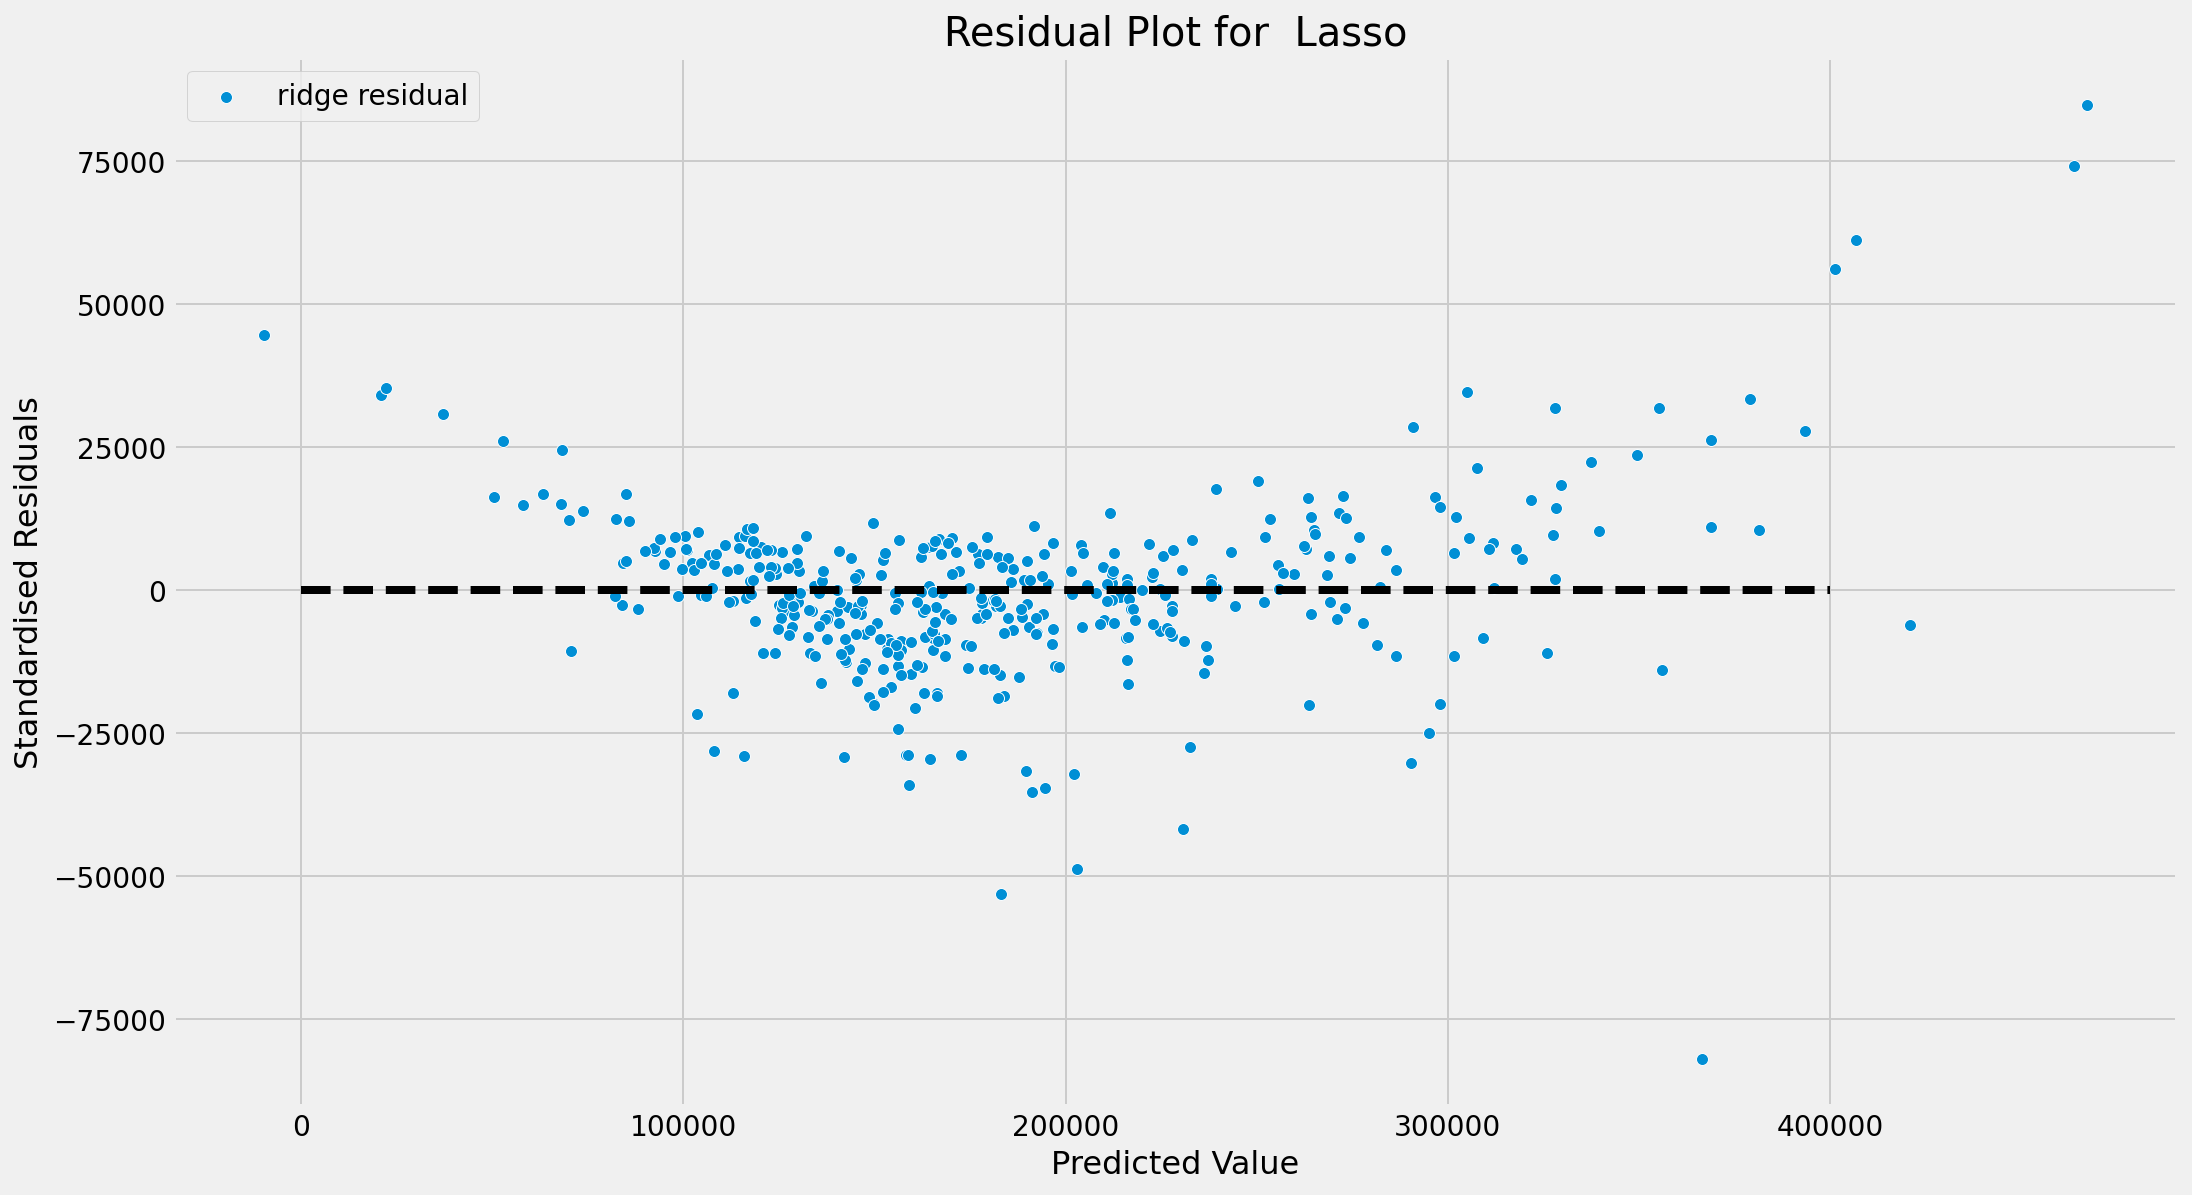

In [141]:
plt.figure(figsize = (16,9))
residual_lasso = y_val - y_pred

sns.scatterplot(x = y_pred,
                y = residual_lasso,
                label = 'ridge residual')

plt.xlabel('Predicted Value' , fontsize = 16)
plt.ylabel('Standardised Residuals' , fontsize = 16)
plt.hlines(y = 0 , xmin = 0 , xmax = 400000 , color = 'black' , linestyles = '--')
plt.legend()
plt.title('Residual Plot for  Lasso' , fontsize = 20)